In [1]:
import joblib
import pickle

import time
import datetime
import numpy as np
import pandas as pd
from keras.src.saving import load_model
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer
from nltk import word_tokenize
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.src.utils import pad_sequences
from tensorflow.keras.preprocessing.text import tokenizer_from_json

from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
from sklearn.metrics import matthews_corrcoef

from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
device = torch.device("cpu")
device

device(type='cpu')

### Funktionen

#### Datenvorbereitung etc.

In [4]:
def create_dataset(tokenizer, max_len, labels_data, tweets_data):
    input_ids = []
    attention_masks = []

    for tweet in tweets_data:
        encoded_dict = tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=256,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels_data)
    dataset = TensorDataset(input_ids, attention_masks, labels)

    return dataset

In [5]:
def get_dataloader(batch_size, dataset, sampler):
    if sampler == "random":
        return DataLoader(
            dataset,
            sampler=RandomSampler(dataset),
            batch_size=batch_size
        )

    if sampler == "sequential":
        return DataLoader(
            dataset,
            sampler=SequentialSampler(dataset),
            batch_size=batch_size
        )

In [6]:
def get_max_len(tweets, tokenizer):
    max_len = 0

    for sent in tweets:
        input_ids = tokenizer.encode(sent, add_special_tokens=True)
        max_len = max(max_len, len(input_ids))
    return max_len

In [7]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [8]:
def vectorize_w2v(tweets, loaded_vectorizer, vector_size=300):
    x_tokenized = tweets.map(word_tokenize)

    def w2v_vector(x_tokenized, vector_size):
        vec = np.zeros(vector_size).reshape((1, vector_size))
        count = 0
        for word in x_tokenized:
            try:
                vec += loaded_vectorizer.wv[word].reshape((1, vector_size))
                count += 1
            except KeyError:

                continue
        if count != 0:
            vec /= count
        return vec

    tweets_w2v = np.zeros((len(x_tokenized), 300))
    for i in range(len(x_tokenized)):
        tweets_w2v[i, :] = w2v_vector(x_tokenized.iloc[i], 300)

    return tweets_w2v

In [9]:
def tokenize_and_vectorize_for_lstm(tokenizer, glove_embeddings, tweets, vector_size=200, max_seq_len=50):
    X_sequences = tokenizer.texts_to_sequences(tweets)
    X_padded = pad_sequences(X_sequences, padding='post', maxlen=max_seq_len)

    def get_glove_vectors(sequence, glove_embeddings, vector_size, max_seq_len):
        vectors = [glove_embeddings.get(tokenizer.index_word.get(idx, ''), np.zeros(vector_size)) for idx in sequence]

        # Padding sicherstellen
        if len(vectors) < max_seq_len:
            vectors.extend([np.zeros(vector_size)] * (max_seq_len - len(vectors)))
        else:
            vectors = vectors[:max_seq_len]

        return np.array(vectors, dtype=np.float32)

    X_vectors = np.array([get_glove_vectors(seq, glove_embeddings, vector_size, max_seq_len) for seq in X_padded],
                         dtype=np.float32)

    return X_vectors

#### Evaluationsfunktionen

In [10]:
def print_wordcloud(dataframe, tweet_col, label_col):
    dataset_0_text = " ".join(dataframe[dataframe[label_col] == 0][tweet_col].tolist())
    dataset_1_text = " ".join(dataframe[dataframe[label_col] == 1][tweet_col].tolist())

    plt.figure(figsize=(12, 6))

    # Subplot 1: Dataset 0
    plt.subplot(1, 2, 1)
    wordcloud = WordCloud(stopwords=None, width=800, height=480, max_words=100, colormap='RdYlGn').generate(
        dataset_0_text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Worthäufigkeit in falsch vorhergesagten Tweets (Label 0)", fontsize=14)

    # Subplot 2: Dataset 1
    plt.subplot(1, 2, 2)
    wordcloud = WordCloud(stopwords=None, width=800, height=480, max_words=100, colormap='Paired').generate(
        dataset_1_text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Worthäufigkeit in falsch vorhergesagten Tweets (Label 1)", fontsize=14)

    plt.tight_layout()
    plt.show()

##### Metriken

In [11]:
def get_predictions_bert(test_dataloader, model):
    predictions = []
    print("Prediction start.")
    total_t0 = time.time()
    batches_completed = 0

    for batch in test_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        with torch.no_grad():
            output = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask)
            logits = output.logits
            logits = logits.detach().cpu().numpy()
            pred_flat = np.argmax(logits, axis=1).flatten()

            predictions.extend(list(pred_flat))

        batches_completed += 1

    print("Total Prediction took {:} (h:mm:ss)".format(format_time(time.time() - total_t0)))
    return predictions

In [12]:
def add_to_eval_df(model_name, y_prediction, y_true, sample_size, df, dataset_name, threshold):
    accuracy = accuracy_score(y_true=y_true, y_pred=y_prediction)
    precision = precision_score(y_true, y_prediction)
    recall = recall_score(y_true, y_prediction)
    f1 = f1_score(y_true, y_prediction)
    mcc = matthews_corrcoef(y_true, y_prediction)

    df.loc[len(df.index)] = [model_name, dataset_name, sample_size, threshold, accuracy, precision, recall, f1, mcc]

In [13]:
def eval_model_bert(tokenizer, model, model_name, labels, tweets, batch_size, data_size, df, dataset_name, threshold,
                    max_len=None):
    if max_len is None:
        max_len = get_max_len(tweets, tokenizer)
    dataset = create_dataset(tokenizer=tokenizer, max_len=max_len, labels_data=labels,
                             tweets_data=tweets)
    dataloader = get_dataloader(batch_size=batch_size, sampler="sequential", dataset=dataset)
    predictions = get_predictions_bert(test_dataloader=dataloader, model=model)

    add_to_eval_df(
        model_name=model_name,
        y_prediction=predictions,
        y_true=labels,
        sample_size=data_size,
        df=df,
        dataset_name=dataset_name,
        threshold=threshold
    )

In [14]:
# geeignet für tf-idf bayes und ensemble
def eval_classic_model(vectorizer, model, model_name, labels, tweets, data_size, df, dataset_name, threshold):
    X_vectorized = vectorizer.transform(tweets)
    predictions = (model.predict_proba(X_vectorized)[:, 1] >= threshold)

    add_to_eval_df(
        model_name=model_name,
        y_prediction=predictions,
        y_true=labels,
        sample_size=data_size,
        df=df,
        dataset_name=dataset_name,
        threshold=threshold
    )

In [15]:
def eval_model_svm(vectorizer, model, model_name, labels, tweets, data_size, df, dataset_name, threshold):
    X_vectorized = vectorizer.transform(tweets)
    predictions = model.predict(X_vectorized)

    add_to_eval_df(
        model_name=model_name,
        y_prediction=predictions,
        y_true=labels,
        sample_size=data_size,
        df=df,
        dataset_name=dataset_name,
        threshold=threshold
    )

In [16]:
def eval_model_gru(tokenizer, model, model_name, labels, tweets, data_size, df, dataset_name, threshold, max_len):
    X_data = [str(x) for x in tweets]
    tweets_seq = tokenizer.texts_to_sequences(X_data)
    tweets_padded = pad_sequences(tweets_seq, padding='post', maxlen=max_len)
    predictions = (model.predict(tweets_padded) > threshold).astype(int)

    add_to_eval_df(
        model_name=model_name,
        y_prediction=predictions,
        y_true=labels,
        sample_size=data_size,
        df=df,
        dataset_name=dataset_name,
        threshold=threshold
    )

In [17]:
def eval_model_lstm(tokenizer, vectorizer, model, labels, tweets, threshold, model_name, data_size, df, dataset_name):
    X_data_vectorized = tokenize_and_vectorize_for_lstm(
        glove_embeddings=vectorizer,
        tweets=tweets,
        tokenizer=tokenizer
    )

    predictions = (model.predict(X_data_vectorized) > threshold).astype(int)

    add_to_eval_df(
        model_name=model_name,
        y_prediction=predictions,
        y_true=labels,
        sample_size=data_size,
        df=df,
        dataset_name=dataset_name,
        threshold=threshold
    )

##### Wahrscheinlichkeiten

In [18]:
def get_predictions_with_probabilities_bert(test_dataloader, model, threshold):
    predictions = []
    predictions_proba = []
    print("Prediction start.")
    total_t0 = time.time()
    batches_completed = 0

    for batch in test_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        with torch.no_grad():
            output = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask)
            logits = output.logits
            logits = logits.detach().cpu().numpy()
            pred_flat = np.argmax(logits, axis=1).flatten()

            pred_with_thresh = [1 if value[1] > threshold else 0 for value in output.logits.softmax(dim=-1).tolist()]
            pred_with_thresh = np.array(pred_with_thresh)

            predictions.extend(list(pred_with_thresh))
            predictions_proba.extend(output.logits.softmax(dim=-1).tolist())

        batches_completed += 1

    print("Prediction finished.")
    print("Total Prediction took {:} (h:mm:ss)".format(format_time(time.time() - total_t0)))
    return predictions, predictions_proba

In [19]:
def add_to_detail_eval_df(dataframe, predictions, probabilities=None):
    if probabilities is not None:
        dataframe["zero_proba"] = pd.Series((v[0] for v in probabilities), index=dataframe.index)
        dataframe["one_proba"] = pd.Series((v[1] for v in probabilities), index=dataframe.index)
    else:
        dataframe["zero_proba"] = 0
        dataframe["one_proba"] = 0
    dataframe["pred"] = predictions

    return dataframe

In [20]:
def add_pred_and_probas_bert(model, tokenizer, data, label_name, tweet_name, batch_size, threshold):
    x_data = data[tweet_name].values
    y_data = data[label_name].values
    max_len = get_max_len(x_data, tokenizer)
    test_dataset = create_dataset(tokenizer=tokenizer, max_len=max_len, labels_data=y_data,
                                  tweets_data=x_data)
    test_dataloader = get_dataloader(batch_size=batch_size, sampler="sequential", dataset=test_dataset)

    predictions, predictions_proba = get_predictions_with_probabilities_bert(test_dataloader=test_dataloader,
                                                                             model=model, threshold=threshold)

    add_to_detail_eval_df(dataframe=data,
                          predictions=predictions,
                          probabilities=predictions_proba)

In [21]:
def add_pred_and_probas(model, vectorizer, data, tweet_name, threshold):
    x_data = data[tweet_name].values

    X_vectorized = vectorizer.transform(x_data)
    probabilities = model.predict_proba(X_vectorized)
    predictions = (probabilities[:, 1] >= threshold).astype(int)

    add_to_detail_eval_df(dataframe=data,
                          predictions=predictions,
                          probabilities=probabilities)

    return data

In [22]:
def add_pred_and_probas_svm(model, vectorizer, data, tweet_name, threshold):
    x_data = data[tweet_name].values

    X_vectorized = vectorizer.transform(x_data)
    predictions = model.predict(X_vectorized)

    add_to_detail_eval_df(dataframe=data,
                          predictions=predictions)

    return data

In [23]:
def add_pred_and_probas_gru(model, tokenizer, data, tweet_name, threshold, max_len):
    x_data = data[tweet_name].values

    X_data = [str(x) for x in x_data]
    tweets_seq = tokenizer.texts_to_sequences(X_data)
    tweets_padded = pad_sequences(tweets_seq, padding='post', maxlen=max_len)

    probabilities = model.predict(tweets_padded)
    predictions = (probabilities > threshold).astype(int)

    new_array = []
    for proba in probabilities:
        complement = 1 - proba[0]
        new_array.append([complement, proba[0]])
    probabilities = pd.Series(new_array)

    add_to_detail_eval_df(dataframe=data,
                          predictions=predictions,
                          probabilities=probabilities)

    return data

In [24]:
def add_pred_and_probas_lstm(model, tokenizer, vectorizer, data, tweet_name, threshold):
    x_data = data[tweet_name].values

    X_data_vectorized = tokenize_and_vectorize_for_lstm(
        glove_embeddings=vectorizer,
        tweets=x_data,
        tokenizer=tokenizer
    )

    probabilities = model.predict(X_data_vectorized)
    predictions = (probabilities > threshold).astype(int)

    new_array = []
    for proba in probabilities:
        complement = 1 - proba[0]
        new_array.append([complement, proba[0]])
    probabilities = pd.Series(new_array)

    add_to_detail_eval_df(dataframe=data,
                          predictions=predictions,
                          probabilities=probabilities)

    return data

### 1. Modelle

In [125]:
MODELS_PATH = "../../webapp/backend/app/models"

#### 1.1 Bayes

In [126]:
nb_vectorizer = joblib.load(MODELS_PATH + "/nb/vectorizer_nb_tfidf.joblib")
nb_model = joblib.load(MODELS_PATH + "/nb/model_nb_tfidf_comp.joblib")
nb_modelname = "ComplementNB"

#### 1.2 Ensemble

In [127]:
ensemble_vectorizer = joblib.load(MODELS_PATH + "/ensemble/tfidf_vectorizer_for_brf.joblib")
ensemble_model = joblib.load(MODELS_PATH + "/ensemble/tfidf_balancedrandomforest.joblib")
ensemble_modelname = "BalancedRandomForest"

#### 1.3 SVM

In [128]:
svm_vectorizer = joblib.load(MODELS_PATH + "/svc/tfidf_vectorizer_svc_linear.joblib")
svm_model = joblib.load(MODELS_PATH + "/svc/svc_linear_best.joblib")
svm_modelname = "LinearSVC"

#### 1.4 RNN-GRU

In [129]:
max_len_gru = 40
gru_model = load_model(MODELS_PATH + "/gru/gru-model_mixed-dataset.keras")
with open(MODELS_PATH + "/gru/tokenizer_mixed-dataset.pkl", 'rb') as f:
    gru_tokenizer = pickle.load(f)
gru_modelname = "RNN-GRU"

#### 1.5 RNN-LSTM

In [130]:
lstm_model = load_model(MODELS_PATH + "/lstm/model_lstm_17.keras")
with open(MODELS_PATH + "/lstm/tokenizer_lstm.json", "r", encoding="utf-8") as f:
    tokenizer_data = f.read()
    lstm_tokenizer = tokenizer_from_json(tokenizer_data)
lstm_glove_embeddings = {}
with open(MODELS_PATH + "/lstm/glove.6B.200d.txt", encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        lstm_glove_embeddings[word] = vector
lstm_modelname = "RNN-LSTM"

#### 1.6 BERT

In [131]:
PATH_BERT_TUNED = MODELS_PATH + "/bert/bert_mixed_imran"
bert_tokenizer = BertTokenizer.from_pretrained(PATH_BERT_TUNED, local_files_only=True)
bert_model = AutoModelForSequenceClassification.from_pretrained(PATH_BERT_TUNED, local_files_only=True)
bert_modelname = "bert_tuned_uncased"

#### 1.7 RoBERTa

In [132]:
PATH_ROBERTA_TUNED = MODELS_PATH + "/roberta/roberta_hate_mixed_cleaned"
roberta_tokenizer = AutoTokenizer.from_pretrained(PATH_ROBERTA_TUNED, local_files_only=True)
roberta_model = AutoModelForSequenceClassification.from_pretrained(PATH_ROBERTA_TUNED, local_files_only=True)
roberta_modelname = "roberta_hate_mixed_cleaned"

### 2. Daten

In [25]:
sample_size = None  # setzen, um nur für eine Stichprobe der Daten die Metriken zu bestimmen

#### 2.1 Mixed-Train (cleaned)

In [26]:
df_mixed_train_cleaned = pd.read_csv("../../data/mixed_dataset/train_cleaned.csv", index_col=0)
df_mixed_train_cleaned = df_mixed_train_cleaned[df_mixed_train_cleaned.tweet_cleaned.notna()]
if sample_size is not None:
    df_mixed_train_cleaned = df_mixed_train_cleaned.sample(n=sample_size)

df_mixed_train_cleaned = df_mixed_train_cleaned[["label", "tweet_cleaned"]]
df_mixed_train_cleaned.head(1)

,label,tweet_cleaned
140232,0,"nickis "" good pout buy botox trade mark mkr"


#### 2.2 Mixed-Train (cleaned-rnn)

In [27]:
df_mixed_train_cleaned_rnn = pd.read_csv("../../data/mixed_dataset/train_cleaned_rnn.csv", index_col=0)
df_mixed_train_cleaned_rnn = df_mixed_train_cleaned_rnn[df_mixed_train_cleaned_rnn.tweet_cleaned.notna()]
if sample_size is not None:
    df_mixed_train_cleaned_rnn = df_mixed_train_cleaned_rnn.sample(n=sample_size)

df_mixed_train_cleaned_rnn = df_mixed_train_cleaned_rnn[["label", "tweet_cleaned"]]
df_mixed_train_cleaned_rnn.head(1)

,label,tweet_cleaned
140232,0,"nickis ""thats not good"" pout bought to you by ..."


#### 2.3 Mixed-Train (uncleaned)

In [28]:
df_mixed_train_uncleaned = pd.read_csv("../../data/mixed_dataset/train_cleaned.csv", index_col=0)
df_mixed_train_uncleaned = df_mixed_train_uncleaned[df_mixed_train_uncleaned.tweet.notna()]
if sample_size is not None:
    df_mixed_train_uncleaned = df_mixed_train_uncleaned.sample(n=sample_size)

df_mixed_train_uncleaned = df_mixed_train_uncleaned[["label", "tweet"]]
print(df_mixed_train_uncleaned.head(1))
print("Daten: \t", len(df_mixed_train_uncleaned))

        label                                              tweet
140232      0  Nicki's "that's not good" pout bought to you b...
Daten: 	 81905


#### 2.4 Mixed-Test (cleaned)

In [29]:
df_mixed_test_cleaned = pd.read_csv("../../data/mixed_dataset/test_cleaned.csv", index_col=0)
df_mixed_test_cleaned = df_mixed_test_cleaned[df_mixed_test_cleaned.tweet_cleaned.notna()]
if sample_size is not None:
    df_mixed_test_cleaned = df_mixed_test_cleaned.sample(n=sample_size)

df_mixed_test_cleaned = df_mixed_test_cleaned[["label", "tweet_cleaned"]]
print(df_mixed_test_cleaned.head(1))
print("Daten: \t", len(df_mixed_test_cleaned))

      label                                 tweet_cleaned
8886      0  final gear evening butterfly stage hope like
Daten: 	 32466


#### 2.5 Mixed-Test (cleaned-RNN)

In [30]:
df_mixed_test_cleaned_rnn = pd.read_csv("../../data/mixed_dataset/test_cleaned_rnn.csv", index_col=0)
df_mixed_test_cleaned_rnn = df_mixed_test_cleaned_rnn[df_mixed_test_cleaned_rnn.tweet_cleaned.notna()]
if sample_size is not None:
    df_mixed_test_cleaned_rnn = df_mixed_test_cleaned_rnn.sample(n=sample_size)

df_mixed_test_cleaned_rnn = df_mixed_test_cleaned_rnn[["label", "tweet_cleaned"]]
print(df_mixed_test_cleaned_rnn.head(1))
print("Daten: \t", len(df_mixed_test_cleaned_rnn))

      label                                      tweet_cleaned
8886      0  cinemaaawards final rehearsals gearing up for ...
Daten: 	 32529


#### 2.6 Mixed-Test (uncleaned)

In [31]:
df_mixed_test_uncleaned = pd.read_csv("../../data/mixed_dataset/test_cleaned.csv", index_col=0)
df_mixed_test_uncleaned = df_mixed_test_uncleaned[df_mixed_test_uncleaned.tweet.notna()]
if sample_size is not None:
    df_mixed_test_uncleaned = df_mixed_test_uncleaned.sample(n=sample_size)

df_mixed_test_uncleaned = df_mixed_test_uncleaned[["label", "tweet", ]]
print(df_mixed_test_uncleaned.head(1))
print("Daten: \t", len(df_mixed_test_uncleaned))

      label                                              tweet
8886      0   @user #cinemaaawards final rehearsals!! geari...
Daten: 	 32582


#### 2.7 Mixed-Test (manual-labeled, uncleaned, new)

In [32]:
df_mixed_manual_uncleaned_new = pd.read_csv("../../data/manual_labeled/manual_labeled_group.csv", index_col=0)
df_mixed_manual_uncleaned_new = df_mixed_manual_uncleaned_new[df_mixed_manual_uncleaned_new.tweet.notna()]

df_mixed_manual_uncleaned_new = df_mixed_manual_uncleaned_new[["label_manual", "tweet", ]]
print(df_mixed_manual_uncleaned_new.head(1))
print("Daten: \t", len(df_mixed_manual_uncleaned_new))

   label_manual                                  tweet
0             1  Post the shit or kill yourself faggot
Daten: 	 498


#### 2.8 Mixed-Test (manual-labeled, uncleaned, old)

In [33]:
df_mixed_manual_uncleaned_old = pd.read_csv("../../data/manual_labeled/manual_labeled_group.csv", index_col=0)
df_mixed_manual_uncleaned_old = df_mixed_manual_uncleaned_old[df_mixed_manual_uncleaned_old.label.notna()]

df_mixed_manual_uncleaned_old = df_mixed_manual_uncleaned_old[["label", "tweet", ]]
print(df_mixed_manual_uncleaned_old.head(1))
print("Daten: \t", len(df_mixed_manual_uncleaned_old))

   label                                  tweet
0      1  Post the shit or kill yourself faggot
Daten: 	 498


### 3. Allgemeine Evaluation - Metriken

In [34]:
def evaluate(label_col, tweet_col, data, dataset_name, threshold):
    evaluation_df = pd.DataFrame(
        columns=["model", "dataset_name", "sample_size", "threshold", "accuracy", "precision", "recall", "f1_score",
                 "mcc"])
    eval_classic_model(vectorizer=ensemble_vectorizer,
                       model=ensemble_model,
                       model_name=ensemble_modelname,
                       labels=data[label_col],
                       tweets=data[tweet_col],
                       data_size=len(data),
                       df=evaluation_df,
                       dataset_name=dataset_name,
                       threshold=threshold)

    eval_classic_model(vectorizer=nb_vectorizer,
                       model=nb_model,
                       model_name=nb_modelname,
                       labels=data[label_col],
                       tweets=data[tweet_col],
                       data_size=len(data),
                       df=evaluation_df,
                       dataset_name=dataset_name,
                       threshold=threshold)

    eval_model_svm(vectorizer=svm_vectorizer,
                   model=svm_model,
                   model_name=svm_modelname,
                   labels=data[label_col],
                   tweets=data[tweet_col],
                   data_size=len(data),
                   df=evaluation_df,
                   dataset_name=dataset_name,
                   threshold="None")

    eval_model_lstm(tokenizer=lstm_tokenizer,
                    vectorizer=lstm_glove_embeddings,
                    model=lstm_model,
                    model_name=lstm_modelname,
                    labels=data[label_col],
                    tweets=data[tweet_col],
                    data_size=len(data),
                    df=evaluation_df,
                    dataset_name=dataset_name,
                    threshold=threshold)

    eval_model_gru(tokenizer=gru_tokenizer,
                   model=gru_model,
                   model_name=gru_modelname,
                   labels=data[label_col],
                   tweets=data[tweet_col],
                   data_size=len(data),
                   df=evaluation_df,
                   dataset_name=dataset_name,
                   threshold=threshold,
                   max_len=40)

    eval_model_bert(tokenizer=bert_tokenizer,
                    model=bert_model,
                    model_name=bert_modelname,
                    labels=data[label_col].values,
                    tweets=data[tweet_col].values,
                    batch_size=16,
                    data_size=len(data),
                    df=evaluation_df,
                    dataset_name=dataset_name,
                    threshold=threshold)

    eval_model_bert(tokenizer=roberta_tokenizer,
                    model=roberta_model,
                    model_name=roberta_modelname,
                    labels=data[label_col].values,
                    tweets=data[tweet_col].values,
                    batch_size=16,
                    data_size=len(data),
                    df=evaluation_df,
                    dataset_name=dataset_name,
                    threshold=threshold)

    return evaluation_df

#### 3.1 Alle Datensätze - Schwellwert 0.5

##### 3.1.1 Mixed-Train (cleaned) - df_mixed_train_cleaned

In [35]:
evaluation_mixed_train_cleaned = pd.read_csv("evaluation_data/evaluation_mixed_train_cleaned.csv", index_col=0)

In [36]:
evaluation_mixed_train_cleaned.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
6,roberta_hate_mixed_cleaned,df_mixed_train_cleaned,81904,0.5,0.923740,0.807912,0.756189,0.781195,0.735669
5,bert_tuned_uncased,df_mixed_train_cleaned,81904,0.5,0.906244,0.719250,0.786029,0.751158,0.694577
0,BalancedRandomForest,df_mixed_train_cleaned,81904,0.5,0.887112,0.630129,0.902950,0.742265,0.690745
4,RNN-GRU,df_mixed_train_cleaned,81904,0.5,0.825088,0.508996,0.803866,0.623317,0.539672
2,LinearSVC,df_mixed_train_cleaned,81904,NaN,0.795358,0.462185,0.835537,0.595155,0.510106
1,ComplementNB,df_mixed_train_cleaned,81904,0.5,0.772966,0.429482,0.795117,0.557715,0.459057
3,RNN-LSTM,df_mixed_train_cleaned,81904,0.5,0.709245,0.365465,0.835402,0.508483,0.403604


##### 3.1.2 Mixed-Train (cleaned-RNN) - df_mixed_train_cleaned_rnn

In [37]:
evaluation_mixed_train_cleaned_rnn = pd.read_csv("evaluation_data/evaluation_mixed_train_cleaned_rnn.csv", index_col=0)

In [38]:
evaluation_mixed_train_cleaned_rnn.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
4,RNN-GRU,df_mixed_train_cleaned_rnn,83305,0.5,0.935286,0.739827,0.985809,0.845286,0.818682
5,bert_tuned_uncased,df_mixed_train_cleaned_rnn,83305,0.5,0.852722,0.571124,0.717585,0.636032,0.550787
6,roberta_hate_mixed_cleaned,df_mixed_train_cleaned_rnn,83305,0.5,0.865218,0.617802,0.651382,0.634148,0.551902
0,BalancedRandomForest,df_mixed_train_cleaned_rnn,83305,0.5,0.838029,0.537481,0.694022,0.605802,0.512486
2,LinearSVC,df_mixed_train_cleaned_rnn,83305,NaN,0.802257,0.467059,0.727960,0.569029,0.467146
3,RNN-LSTM,df_mixed_train_cleaned_rnn,83305,0.5,0.753916,0.410159,0.849722,0.553260,0.462617
1,ComplementNB,df_mixed_train_cleaned_rnn,83305,0.5,0.640874,0.317697,0.873619,0.465949,0.355760


##### 3.1.3 Mixed-Train (uncleaned) - df_mixed_train_uncleaned

In [39]:
evaluation_mixed_train_uncleaned = pd.read_csv("evaluation_data/evaluation_mixed_train_uncleaned.csv", index_col=0)

In [40]:
evaluation_mixed_train_uncleaned.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
4,RNN-GRU,df_mixed_train_uncleaned,81905,0.5,0.908724,0.693561,0.883215,0.776982,0.728963
5,bert_tuned_uncased,df_mixed_train_uncleaned,81905,0.5,0.830731,0.523727,0.659410,0.583789,0.484309
6,roberta_hate_mixed_cleaned,df_mixed_train_uncleaned,81905,0.5,0.826177,0.513170,0.671211,0.581646,0.481209
0,BalancedRandomForest,df_mixed_train_uncleaned,81905,0.5,0.823747,0.508095,0.657714,0.573303,0.470679
2,LinearSVC,df_mixed_train_uncleaned,81905,NaN,0.791002,0.450680,0.735300,0.558837,0.454280
3,RNN-LSTM,df_mixed_train_uncleaned,81905,0.5,0.754704,0.409119,0.816073,0.545010,0.446330
1,ComplementNB,df_mixed_train_uncleaned,81905,0.5,0.666138,0.332251,0.846253,0.477161,0.364599


##### 3.1.4 Mixed-Test (cleaned) - df_mixed_test_cleaned

In [41]:
evaluation_mixed_test_cleaned = pd.read_csv("evaluation_data/evaluation_mixed_test_cleaned.csv", index_col=0)

In [42]:
evaluation_mixed_test_cleaned.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
5,bert_tuned_uncased,df_mixed_test_cleaned,32466,0.5,0.823292,0.573525,0.628454,0.599735,0.487495
6,roberta_hate_mixed_cleaned,df_mixed_test_cleaned,32466,0.5,0.833303,0.614069,0.561632,0.586681,0.483293
0,BalancedRandomForest,df_mixed_test_cleaned,32466,0.5,0.771453,0.471478,0.702149,0.564145,0.432463
2,LinearSVC,df_mixed_test_cleaned,32466,NaN,0.719707,0.412466,0.778915,0.539334,0.402253
4,RNN-GRU,df_mixed_test_cleaned,32466,0.5,0.746535,0.436518,0.698786,0.537359,0.395096
1,ComplementNB,df_mixed_test_cleaned,32466,0.5,0.714070,0.402939,0.741775,0.522209,0.375304
3,RNN-LSTM,df_mixed_test_cleaned,32466,0.5,0.654192,0.359142,0.817956,0.499130,0.349701


##### 3.1.5 Mixed-Test (cleaned-RNN) - df_mixed_test_cleaned_rnn

In [43]:
evaluation_mixed_test_cleaned_rnn = pd.read_csv("evaluation_data/evaluation_mixed_test_cleaned_rnn.csv", index_col=0)

In [44]:
evaluation_mixed_test_cleaned_rnn.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
6,roberta_hate_mixed_cleaned,df_mixed_test_cleaned_rnn,32529,0.5,0.820929,0.568380,0.618790,0.592515,0.478740
5,bert_tuned_uncased,df_mixed_test_cleaned_rnn,32529,0.5,0.801869,0.522474,0.677674,0.590039,0.469069
4,RNN-GRU,df_mixed_test_cleaned_rnn,32529,0.5,0.782625,0.488139,0.682496,0.569183,0.439911
0,BalancedRandomForest,df_mixed_test_cleaned_rnn,32529,0.5,0.768484,0.461981,0.609877,0.525726,0.382776
3,RNN-LSTM,df_mixed_test_cleaned_rnn,32529,0.5,0.692828,0.388637,0.802601,0.523691,0.383323
2,LinearSVC,df_mixed_test_cleaned_rnn,32529,NaN,0.736451,0.420899,0.672122,0.517639,0.367362
1,ComplementNB,df_mixed_test_cleaned_rnn,32529,0.5,0.571367,0.311006,0.853448,0.455883,0.288504


##### 3.1.6 Mixed-Test (uncleaned) - df_mixed_test_uncleaned

In [45]:
evaluation_mixed_test_uncleaned = pd.read_csv("evaluation_data/evaluation_mixed_test_uncleaned.csv", index_col=0)

In [46]:
evaluation_mixed_test_uncleaned.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
6,roberta_hate_mixed_cleaned,df_mixed_test_uncleaned,32582,0.5,0.790498,0.500997,0.660579,0.569826,0.442052
5,bert_tuned_uncased,df_mixed_test_uncleaned,32582,0.5,0.781045,0.484156,0.647428,0.554014,0.420551
4,RNN-GRU,df_mixed_test_uncleaned,32582,0.5,0.782088,0.485828,0.641146,0.552784,0.419261
3,RNN-LSTM,df_mixed_test_uncleaned,32582,0.5,0.696888,0.389729,0.782876,0.520396,0.376852
0,BalancedRandomForest,df_mixed_test_uncleaned,32582,0.5,0.762415,0.450806,0.600526,0.515005,0.368400
2,LinearSVC,df_mixed_test_uncleaned,32582,NaN,0.724357,0.406608,0.679719,0.508832,0.354964
1,ComplementNB,df_mixed_test_uncleaned,32582,0.5,0.596495,0.321717,0.830947,0.463847,0.298526


##### 3.1.7 Mixed-Test (manual-labeled, uncleaned, new) - df_mixed_manual_uncleaned_new

In [47]:
evaluation_mixed_manual_uncleaned_new = pd.read_csv("evaluation_data/evaluation_mixed_manual_uncleaned_new.csv", index_col=0)

In [48]:
evaluation_mixed_manual_uncleaned_new.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
6,roberta_hate_mixed_cleaned,df_mixed_manual_uncleaned_new,498,0.5,0.891566,0.909910,0.855932,0.882096,0.783151
5,bert_tuned_uncased,df_mixed_manual_uncleaned_new,498,0.5,0.827309,0.812500,0.826271,0.819328,0.654050
3,RNN-LSTM,df_mixed_manual_uncleaned_new,498,0.5,0.795181,0.727891,0.906780,0.807547,0.610671
2,LinearSVC,df_mixed_manual_uncleaned_new,498,NaN,0.809237,0.783133,0.826271,0.804124,0.619319
4,RNN-GRU,df_mixed_manual_uncleaned_new,498,0.5,0.817269,0.834101,0.766949,0.799117,0.633943
0,BalancedRandomForest,df_mixed_manual_uncleaned_new,498,0.5,0.807229,0.824074,0.754237,0.787611,0.613782
1,ComplementNB,df_mixed_manual_uncleaned_new,498,0.5,0.746988,0.665663,0.936441,0.778169,0.543140


##### 3.1.8 Mixed-Test (manual-labeled, uncleaned, old) - df_mixed_manual_uncleaned_old

In [49]:
evaluation_mixed_manual_uncleaned_old = pd.read_csv("evaluation_data/evaluation_mixed_manual_uncleaned_old.csv", index_col=0)

In [50]:
evaluation_mixed_manual_uncleaned_old.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
6,roberta_hate_mixed_cleaned,df_mixed_manual_uncleaned_old,498,0.5,0.841365,0.824324,0.820628,0.822472,0.679103
5,bert_tuned_uncased,df_mixed_manual_uncleaned_old,498,0.5,0.797189,0.754167,0.811659,0.781857,0.594238
4,RNN-GRU,df_mixed_manual_uncleaned_old,498,0.5,0.803213,0.788018,0.766816,0.777273,0.601252
2,LinearSVC,df_mixed_manual_uncleaned_old,498,NaN,0.787149,0.734940,0.820628,0.775424,0.577454
3,RNN-LSTM,df_mixed_manual_uncleaned_old,498,0.5,0.761044,0.676871,0.892377,0.769826,0.553039
0,BalancedRandomForest,df_mixed_manual_uncleaned_old,498,0.5,0.773092,0.754630,0.730942,0.742597,0.540036
1,ComplementNB,df_mixed_manual_uncleaned_old,498,0.5,0.696787,0.608434,0.905830,0.727928,0.456863


##### Vergleich aller Datensätze bei Schwellwerte 0.5


In [51]:
df_list_50 = [
    evaluation_mixed_train_cleaned,
    evaluation_mixed_train_cleaned_rnn,
    evaluation_mixed_train_uncleaned,
    evaluation_mixed_test_cleaned,
    evaluation_mixed_test_cleaned_rnn,
    evaluation_mixed_test_uncleaned,
    evaluation_mixed_manual_uncleaned_new,
    evaluation_mixed_manual_uncleaned_old]

all_eval_50_dfs = pd.concat(df_list_50, axis=0)

In [52]:
# allgemeine Sortierung aller Datensätze nach F1-Score
all_eval_50_dfs.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
6,roberta_hate_mixed_cleaned,df_mixed_manual_uncleaned_new,498,0.5,0.891566,0.909910,0.855932,0.882096,0.783151
4,RNN-GRU,df_mixed_train_cleaned_rnn,83305,0.5,0.935286,0.739827,0.985809,0.845286,0.818682
6,roberta_hate_mixed_cleaned,df_mixed_manual_uncleaned_old,498,0.5,0.841365,0.824324,0.820628,0.822472,0.679103
5,bert_tuned_uncased,df_mixed_manual_uncleaned_new,498,0.5,0.827309,0.812500,0.826271,0.819328,0.654050
3,RNN-LSTM,df_mixed_manual_uncleaned_new,498,0.5,0.795181,0.727891,0.906780,0.807547,0.610671
2,LinearSVC,df_mixed_manual_uncleaned_new,498,NaN,0.809237,0.783133,0.826271,0.804124,0.619319
4,RNN-GRU,df_mixed_manual_uncleaned_new,498,0.5,0.817269,0.834101,0.766949,0.799117,0.633943
0,BalancedRandomForest,df_mixed_manual_uncleaned_new,498,0.5,0.807229,0.824074,0.754237,0.787611,0.613782
5,bert_tuned_uncased,df_mixed_manual_uncleaned_old,498,0.5,0.797189,0.754167,0.811659,0.781857,0.594238
6,roberta_hate_mixed_cleaned,df_mixed_train_cleaned,81904,0.5,0.923740,0.807912,0.756189,0.781195,0.735669


In [57]:
# Filterung nur auf die 3 Testdatensätze und Sortierung nach F1-Score
all_eval_50_dfs[(all_eval_50_dfs.dataset_name == "df_mixed_test_cleaned") | (all_eval_50_dfs.dataset_name == "df_mixed_test_cleaned_rnn") | (all_eval_50_dfs.dataset_name == "df_mixed_test_uncleaned")].sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
5,bert_tuned_uncased,df_mixed_test_cleaned,32466,0.5,0.823292,0.573525,0.628454,0.599735,0.487495
6,roberta_hate_mixed_cleaned,df_mixed_test_cleaned_rnn,32529,0.5,0.820929,0.568380,0.618790,0.592515,0.478740
5,bert_tuned_uncased,df_mixed_test_cleaned_rnn,32529,0.5,0.801869,0.522474,0.677674,0.590039,0.469069
6,roberta_hate_mixed_cleaned,df_mixed_test_cleaned,32466,0.5,0.833303,0.614069,0.561632,0.586681,0.483293
6,roberta_hate_mixed_cleaned,df_mixed_test_uncleaned,32582,0.5,0.790498,0.500997,0.660579,0.569826,0.442052
4,RNN-GRU,df_mixed_test_cleaned_rnn,32529,0.5,0.782625,0.488139,0.682496,0.569183,0.439911
0,BalancedRandomForest,df_mixed_test_cleaned,32466,0.5,0.771453,0.471478,0.702149,0.564145,0.432463
5,bert_tuned_uncased,df_mixed_test_uncleaned,32582,0.5,0.781045,0.484156,0.647428,0.554014,0.420551
4,RNN-GRU,df_mixed_test_uncleaned,32582,0.5,0.782088,0.485828,0.641146,0.552784,0.419261
2,LinearSVC,df_mixed_test_cleaned,32466,NaN,0.719707,0.412466,0.778915,0.539334,0.402253


<Axes: xlabel='model', ylabel='f1_score'>

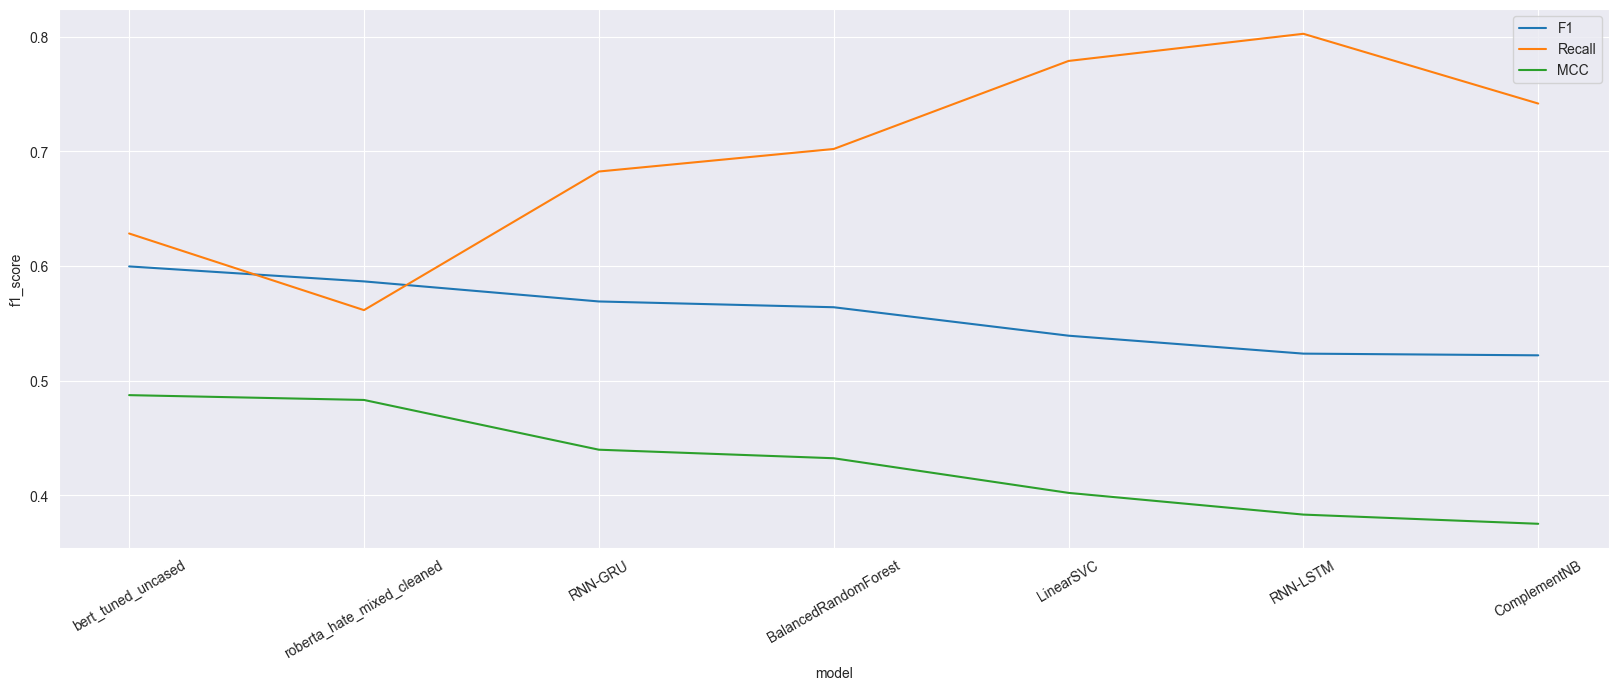

In [69]:
# Filterung nur auf den jeweils besten cleaned Datensatz (für GRU und LSTM der _rnn-Datensatz)
best_cleaned = all_eval_50_dfs[((all_eval_50_dfs.dataset_name == "df_mixed_test_cleaned") & ((all_eval_50_dfs.model != "RNN-GRU") & (all_eval_50_dfs.model != "RNN-LSTM"))) |
                ((all_eval_50_dfs.dataset_name == "df_mixed_test_cleaned_rnn") & ((all_eval_50_dfs.model == "RNN-GRU") | (all_eval_50_dfs.model == "RNN-LSTM")))].sort_values(by=["f1_score"], ascending=False)

fig, ax = plt.subplots(figsize=(20, 7))
plt.xticks(rotation=30)
sns.lineplot(data=best_cleaned, y=best_cleaned.f1_score, x=best_cleaned.model, label="F1")
sns.lineplot(data=best_cleaned, y=best_cleaned.recall, x=best_cleaned.model, label="Recall")
sns.lineplot(data=best_cleaned, y=best_cleaned.mcc, x=best_cleaned.model, label="MCC")

###### Erkenntnisse Schwellwert 0.5
- manuell gelabelte Datensätze erzielen die besten Ergebnisse, alle Modelle unter den besten F1-Werten vertreten
- deutliche Unterschiede (-20-25%) zwischen manuell gelabelt und regulären Testdaten (volle Samplesize)
- cleaned erzielt für das jeweilige Modell grundsätzlich die besten Ergebnisse (bei GRU und LSTM der RNN-Datensatz), ansonsten aber im Schnitt 3-5% Unterschied von cleaned zu uncleaned

#### 3.2 Alle Datensätze - Schwellwert 0.35

##### 3.2.1 Mixed-Train (cleaned) - df_mixed_train_cleaned

In [72]:
evaluation_mixed_train_cleaned2 = pd.read_csv("evaluation_data/evaluation_mixed_train_cleaned2.csv", index_col=0)

In [73]:
evaluation_mixed_train_cleaned2.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
6,roberta_hate_mixed_cleaned,df_mixed_train_cleaned,81904,0.35,0.923740,0.807912,0.756189,0.781195,0.735669
5,bert_tuned_uncased,df_mixed_train_cleaned,81904,0.35,0.906244,0.719250,0.786029,0.751158,0.694577
4,RNN-GRU,df_mixed_train_cleaned,81904,0.35,0.800303,0.469796,0.849712,0.605061,0.524056
0,BalancedRandomForest,df_mixed_train_cleaned,81904,0.35,0.776617,0.443722,0.949407,0.604787,0.543255
2,LinearSVC,df_mixed_train_cleaned,81904,NaN,0.795358,0.462185,0.835537,0.595155,0.510106
3,RNN-LSTM,df_mixed_train_cleaned,81904,0.35,0.675291,0.342362,0.872703,0.491793,0.389101
1,ComplementNB,df_mixed_train_cleaned,81904,0.35,0.589178,0.297868,0.944591,0.452914,0.353772


##### 3.2.2 Mixed-Train (cleaned-RNN) - df_mixed_train_cleaned_rnn

In [74]:
evaluation_mixed_train_cleaned_rnn2 = pd.read_csv("evaluation_data/evaluation_mixed_train_cleaned_rnn2.csv", index_col=0)

In [75]:
evaluation_mixed_train_cleaned_rnn2.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
4,RNN-GRU,df_mixed_train_cleaned_rnn,83305,0.35,0.912358,0.673828,0.990963,0.802189,0.771465
5,bert_tuned_uncased,df_mixed_train_cleaned_rnn,83305,0.35,0.852722,0.571124,0.717585,0.636032,0.550787
6,roberta_hate_mixed_cleaned,df_mixed_train_cleaned_rnn,83305,0.35,0.865218,0.617802,0.651382,0.634148,0.551902
2,LinearSVC,df_mixed_train_cleaned_rnn,83305,NaN,0.802257,0.467059,0.727960,0.569029,0.467146
0,BalancedRandomForest,df_mixed_train_cleaned_rnn,83305,0.35,0.772367,0.429606,0.821943,0.564279,0.471490
3,RNN-LSTM,df_mixed_train_cleaned_rnn,83305,0.35,0.704159,0.368475,0.910101,0.524567,0.439641
1,ComplementNB,df_mixed_train_cleaned_rnn,83305,0.35,0.450153,0.242920,0.976170,0.389030,0.266228


##### 3.2.3 Mixed-Train (uncleaned) - df_mixed_train_uncleaned

In [76]:
evaluation_mixed_train_uncleaned2 = pd.read_csv("evaluation_data/evaluation_mixed_train_uncleaned2.csv", index_col=0)

In [77]:
evaluation_mixed_train_uncleaned2.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
4,RNN-GRU,df_mixed_train_uncleaned,81905,0.35,0.887858,0.630284,0.912106,0.745448,0.695590
5,bert_tuned_uncased,df_mixed_train_uncleaned,81905,0.35,0.830731,0.523727,0.659410,0.583789,0.484309
6,roberta_hate_mixed_cleaned,df_mixed_train_uncleaned,81905,0.35,0.826177,0.513170,0.671211,0.581646,0.481209
2,LinearSVC,df_mixed_train_uncleaned,81905,NaN,0.791002,0.450680,0.735300,0.558837,0.454280
0,BalancedRandomForest,df_mixed_train_uncleaned,81905,0.35,0.757866,0.410456,0.790709,0.540394,0.437011
3,RNN-LSTM,df_mixed_train_uncleaned,81905,0.35,0.705427,0.366869,0.876704,0.517277,0.422561
1,ComplementNB,df_mixed_train_uncleaned,81905,0.35,0.463024,0.247399,0.970973,0.394326,0.272100


##### 3.2.4 Mixed-Test (cleaned) - df_mixed_test_cleaned

In [78]:
evaluation_mixed_test_cleaned2 = pd.read_csv("evaluation_data/evaluation_mixed_test_cleaned2.csv", index_col=0)

In [79]:
evaluation_mixed_test_cleaned2.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
5,bert_tuned_uncased,df_mixed_test_cleaned,32466,0.35,0.823292,0.573525,0.628454,0.599735,0.487495
6,roberta_hate_mixed_cleaned,df_mixed_test_cleaned,32466,0.35,0.833303,0.614069,0.561632,0.586681,0.483293
2,LinearSVC,df_mixed_test_cleaned,32466,NaN,0.719707,0.412466,0.778915,0.539334,0.402253
4,RNN-GRU,df_mixed_test_cleaned,32466,0.35,0.720107,0.410779,0.756690,0.532490,0.390810
0,BalancedRandomForest,df_mixed_test_cleaned,32466,0.35,0.666759,0.372387,0.849101,0.517719,0.381316
3,RNN-LSTM,df_mixed_test_cleaned,32466,0.35,0.617169,0.338402,0.855827,0.485022,0.334524
1,ComplementNB,df_mixed_test_cleaned,32466,0.35,0.524549,0.297518,0.923527,0.450050,0.292803


##### 3.2.5 Mixed-Test (cleaned-RNN) - df_mixed_test_cleaned_rnn

In [80]:
evaluation_mixed_test_cleaned_rnn2 = pd.read_csv("evaluation_data/evaluation_mixed_test_cleaned_rnn2.csv", index_col=0)

In [81]:
evaluation_mixed_test_cleaned_rnn2.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
6,roberta_hate_mixed_cleaned,df_mixed_test_cleaned_rnn,32529,0.35,0.820929,0.568380,0.618790,0.592515,0.478740
5,bert_tuned_uncased,df_mixed_test_cleaned_rnn,32529,0.35,0.801869,0.522474,0.677674,0.590039,0.469069
4,RNN-GRU,df_mixed_test_cleaned_rnn,32529,0.35,0.764180,0.461467,0.723553,0.563528,0.432198
2,LinearSVC,df_mixed_test_cleaned_rnn,32529,NaN,0.736451,0.420899,0.672122,0.517639,0.367362
0,BalancedRandomForest,df_mixed_test_cleaned_rnn,32529,0.35,0.694396,0.383440,0.744302,0.506135,0.352747
3,RNN-LSTM,df_mixed_test_cleaned_rnn,32529,0.35,0.634173,0.350006,0.861923,0.497848,0.355171
1,ComplementNB,df_mixed_test_cleaned_rnn,32529,0.35,0.391866,0.253148,0.969316,0.401452,0.213532


##### 3.2.6 Mixed-Test (uncleaned) - df_mixed_test_uncleaned

In [82]:
evaluation_mixed_test_uncleaned2 = pd.read_csv("evaluation_data/evaluation_mixed_test_uncleaned2.csv", index_col=0)

In [83]:
evaluation_mixed_test_uncleaned2.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
6,roberta_hate_mixed_cleaned,df_mixed_test_uncleaned,32582,0.35,0.790498,0.500997,0.660579,0.569826,0.442052
5,bert_tuned_uncased,df_mixed_test_uncleaned,32582,0.35,0.781045,0.484156,0.647428,0.554014,0.420551
4,RNN-GRU,df_mixed_test_uncleaned,32582,0.35,0.761494,0.455386,0.691262,0.549063,0.412066
2,LinearSVC,df_mixed_test_uncleaned,32582,NaN,0.724357,0.406608,0.679719,0.508832,0.354964
3,RNN-LSTM,df_mixed_test_uncleaned,32582,0.35,0.641029,0.352037,0.843366,0.496730,0.350808
0,BalancedRandomForest,df_mixed_test_uncleaned,32582,0.35,0.685962,0.373507,0.730859,0.494366,0.335205
1,ComplementNB,df_mixed_test_uncleaned,32582,0.35,0.404671,0.256564,0.966540,0.405492,0.222343


##### 3.2.7 Mixed-Test (manual-labeled, uncleaned, new) - df_mixed_manual_uncleaned_new

In [84]:
evaluation_mixed_manual_uncleaned_new2 = pd.read_csv("evaluation_data/evaluation_mixed_manual_uncleaned_new2.csv", index_col=0)

In [85]:
evaluation_mixed_manual_uncleaned_new2.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
6,roberta_hate_mixed_cleaned,df_mixed_manual_uncleaned_new,498,0.35,0.891566,0.909910,0.855932,0.882096,0.783151
5,bert_tuned_uncased,df_mixed_manual_uncleaned_new,498,0.35,0.827309,0.812500,0.826271,0.819328,0.654050
0,BalancedRandomForest,df_mixed_manual_uncleaned_new,498,0.35,0.809237,0.760148,0.872881,0.812623,0.626387
2,LinearSVC,df_mixed_manual_uncleaned_new,498,NaN,0.809237,0.783133,0.826271,0.804124,0.619319
3,RNN-LSTM,df_mixed_manual_uncleaned_new,498,0.35,0.761044,0.681115,0.932203,0.787120,0.563812
4,RNN-GRU,df_mixed_manual_uncleaned_new,498,0.35,0.795181,0.786325,0.779661,0.782979,0.589088
1,ComplementNB,df_mixed_manual_uncleaned_new,498,0.35,0.638554,0.567961,0.991525,0.722222,0.412337


##### 3.2.8 Mixed-Test (manual-labeled, uncleaned, old) - df_mixed_manual_uncleaned_old

In [86]:
evaluation_mixed_manual_uncleaned_old2 = pd.read_csv("evaluation_data/evaluation_mixed_manual_uncleaned_old2.csv", index_col=0)

In [87]:
evaluation_mixed_manual_uncleaned_old2.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
6,roberta_hate_mixed_cleaned,df_mixed_manual_uncleaned_old,498,0.35,0.841365,0.824324,0.820628,0.822472,0.679103
5,bert_tuned_uncased,df_mixed_manual_uncleaned_old,498,0.35,0.797189,0.754167,0.811659,0.781857,0.594238
2,LinearSVC,df_mixed_manual_uncleaned_old,498,NaN,0.787149,0.734940,0.820628,0.775424,0.577454
0,BalancedRandomForest,df_mixed_manual_uncleaned_old,498,0.35,0.775100,0.704797,0.856502,0.773279,0.564710
4,RNN-GRU,df_mixed_manual_uncleaned_old,498,0.35,0.789157,0.752137,0.789238,0.770241,0.576214
3,RNN-LSTM,df_mixed_manual_uncleaned_old,498,0.35,0.734940,0.640867,0.928251,0.758242,0.527498
1,ComplementNB,df_mixed_manual_uncleaned_old,498,0.35,0.604418,0.531553,0.982063,0.689764,0.368687


##### Vergleich aller Datensätze bei Schwellwerte 0.35

In [88]:
df_list_35 = [
    evaluation_mixed_train_cleaned2,
    evaluation_mixed_train_cleaned_rnn2,
    evaluation_mixed_train_uncleaned2,
    evaluation_mixed_test_cleaned2,
    evaluation_mixed_test_cleaned_rnn2,
    evaluation_mixed_test_uncleaned2,
    evaluation_mixed_manual_uncleaned_new2,
    evaluation_mixed_manual_uncleaned_old2]

all_eval_35_dfs = pd.concat(df_list_35, axis=0)

In [90]:
# allgemeine Sortierung aller Datensätze nach F1-Score
all_eval_35_dfs.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
6,roberta_hate_mixed_cleaned,df_mixed_manual_uncleaned_new,498,0.35,0.891566,0.909910,0.855932,0.882096,0.783151
6,roberta_hate_mixed_cleaned,df_mixed_manual_uncleaned_old,498,0.35,0.841365,0.824324,0.820628,0.822472,0.679103
5,bert_tuned_uncased,df_mixed_manual_uncleaned_new,498,0.35,0.827309,0.812500,0.826271,0.819328,0.654050
0,BalancedRandomForest,df_mixed_manual_uncleaned_new,498,0.35,0.809237,0.760148,0.872881,0.812623,0.626387
2,LinearSVC,df_mixed_manual_uncleaned_new,498,NaN,0.809237,0.783133,0.826271,0.804124,0.619319
4,RNN-GRU,df_mixed_train_cleaned_rnn,83305,0.35,0.912358,0.673828,0.990963,0.802189,0.771465
3,RNN-LSTM,df_mixed_manual_uncleaned_new,498,0.35,0.761044,0.681115,0.932203,0.787120,0.563812
4,RNN-GRU,df_mixed_manual_uncleaned_new,498,0.35,0.795181,0.786325,0.779661,0.782979,0.589088
5,bert_tuned_uncased,df_mixed_manual_uncleaned_old,498,0.35,0.797189,0.754167,0.811659,0.781857,0.594238
6,roberta_hate_mixed_cleaned,df_mixed_train_cleaned,81904,0.35,0.923740,0.807912,0.756189,0.781195,0.735669


In [91]:
# Filterung nur auf die 3 Testdatensätze und Sortierung nach F1-Score
all_eval_35_dfs[(all_eval_35_dfs.dataset_name == "df_mixed_test_cleaned") | (all_eval_35_dfs.dataset_name == "df_mixed_test_cleaned_rnn") | (all_eval_35_dfs.dataset_name == "df_mixed_test_uncleaned")].sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
5,bert_tuned_uncased,df_mixed_test_cleaned,32466,0.35,0.823292,0.573525,0.628454,0.599735,0.487495
6,roberta_hate_mixed_cleaned,df_mixed_test_cleaned_rnn,32529,0.35,0.820929,0.568380,0.618790,0.592515,0.478740
5,bert_tuned_uncased,df_mixed_test_cleaned_rnn,32529,0.35,0.801869,0.522474,0.677674,0.590039,0.469069
6,roberta_hate_mixed_cleaned,df_mixed_test_cleaned,32466,0.35,0.833303,0.614069,0.561632,0.586681,0.483293
6,roberta_hate_mixed_cleaned,df_mixed_test_uncleaned,32582,0.35,0.790498,0.500997,0.660579,0.569826,0.442052
4,RNN-GRU,df_mixed_test_cleaned_rnn,32529,0.35,0.764180,0.461467,0.723553,0.563528,0.432198
5,bert_tuned_uncased,df_mixed_test_uncleaned,32582,0.35,0.781045,0.484156,0.647428,0.554014,0.420551
4,RNN-GRU,df_mixed_test_uncleaned,32582,0.35,0.761494,0.455386,0.691262,0.549063,0.412066
2,LinearSVC,df_mixed_test_cleaned,32466,NaN,0.719707,0.412466,0.778915,0.539334,0.402253
4,RNN-GRU,df_mixed_test_cleaned,32466,0.35,0.720107,0.410779,0.756690,0.532490,0.390810


<Axes: xlabel='model', ylabel='f1_score'>

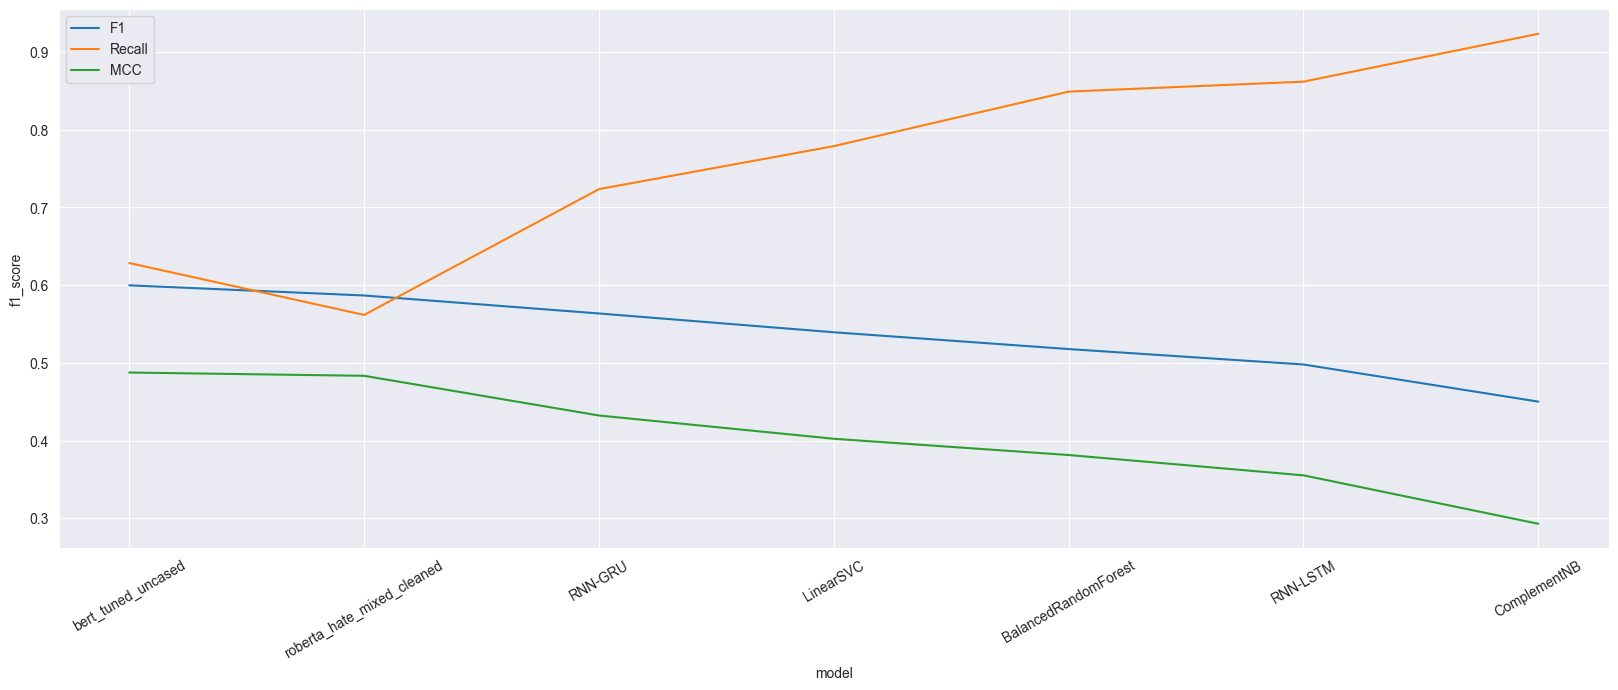

In [92]:
# Filterung nur auf den jeweils besten cleaned Datensatz (für GRU und LSTM der _rnn-Datensatz)
best_cleaned_35 = all_eval_35_dfs[((all_eval_35_dfs.dataset_name == "df_mixed_test_cleaned") & ((all_eval_35_dfs.model != "RNN-GRU") & (all_eval_35_dfs.model != "RNN-LSTM"))) |
                ((all_eval_35_dfs.dataset_name == "df_mixed_test_cleaned_rnn") & ((all_eval_35_dfs.model == "RNN-GRU") | (all_eval_35_dfs.model == "RNN-LSTM")))].sort_values(by=["f1_score"], ascending=False)

fig, ax = plt.subplots(figsize=(20, 7))
plt.xticks(rotation=30)
sns.lineplot(data=best_cleaned_35, y=best_cleaned_35.f1_score, x=best_cleaned_35.model, label="F1")
sns.lineplot(data=best_cleaned_35, y=best_cleaned_35.recall, x=best_cleaned_35.model, label="Recall")
sns.lineplot(data=best_cleaned_35, y=best_cleaned_35.mcc, x=best_cleaned_35.model, label="MCC")

###### Erkenntnisse Schwellwert 0.35
- manuell gelabelte Datensätze erzielen auch bei Schwellwert 0.35 die besten Ergebnisse, alle Modelle unter den besten F1-Werten vertreten
- ebenfalls deutliche Unterschiede (-20-25%) zwischen manuell gelabelt und regulären Testdaten (volle Samplesize)
- cleaned erzielt für das jeweilige Modell grundsätzlich die besten Ergebnisse (bei GRU und LSTM der RNN-Datensatz), ansonsten aber im Schnitt 3-5% Unterschied von cleaned zu uncleaned

#### Gesamtvergleich aller Datensätze und Schwellwerte

In [93]:
df_list = [
    all_eval_50_dfs,
    all_eval_35_dfs]

all_eval_dfs = pd.concat(df_list, axis=0)

In [95]:
# allgemeine Sortierung aller Datensätze nach F1-Score
all_eval_dfs.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
6,roberta_hate_mixed_cleaned,df_mixed_manual_uncleaned_new,498,0.35,0.891566,0.909910,0.855932,0.882096,0.783151
6,roberta_hate_mixed_cleaned,df_mixed_manual_uncleaned_new,498,0.50,0.891566,0.909910,0.855932,0.882096,0.783151
4,RNN-GRU,df_mixed_train_cleaned_rnn,83305,0.50,0.935286,0.739827,0.985809,0.845286,0.818682
6,roberta_hate_mixed_cleaned,df_mixed_manual_uncleaned_old,498,0.35,0.841365,0.824324,0.820628,0.822472,0.679103
6,roberta_hate_mixed_cleaned,df_mixed_manual_uncleaned_old,498,0.50,0.841365,0.824324,0.820628,0.822472,0.679103
...,...,...,...,...,...,...,...,...,...
1,ComplementNB,df_mixed_test_cleaned,32466,0.35,0.524549,0.297518,0.923527,0.450050,0.292803
1,ComplementNB,df_mixed_test_uncleaned,32582,0.35,0.404671,0.256564,0.966540,0.405492,0.222343
1,ComplementNB,df_mixed_test_cleaned_rnn,32529,0.35,0.391866,0.253148,0.969316,0.401452,0.213532
1,ComplementNB,df_mixed_train_uncleaned,81905,0.35,0.463024,0.247399,0.970973,0.394326,0.272100


In [96]:
# Filterung nur auf die 3 Testdatensätze und Sortierung nach F1-Score
all_eval_dfs[(all_eval_dfs.dataset_name == "df_mixed_test_cleaned") | (all_eval_dfs.dataset_name == "df_mixed_test_cleaned_rnn") | (all_eval_dfs.dataset_name == "df_mixed_test_uncleaned")].sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
5,bert_tuned_uncased,df_mixed_test_cleaned,32466,0.50,0.823292,0.573525,0.628454,0.599735,0.487495
5,bert_tuned_uncased,df_mixed_test_cleaned,32466,0.35,0.823292,0.573525,0.628454,0.599735,0.487495
6,roberta_hate_mixed_cleaned,df_mixed_test_cleaned_rnn,32529,0.35,0.820929,0.568380,0.618790,0.592515,0.478740
6,roberta_hate_mixed_cleaned,df_mixed_test_cleaned_rnn,32529,0.50,0.820929,0.568380,0.618790,0.592515,0.478740
5,bert_tuned_uncased,df_mixed_test_cleaned_rnn,32529,0.35,0.801869,0.522474,0.677674,0.590039,0.469069
5,bert_tuned_uncased,df_mixed_test_cleaned_rnn,32529,0.50,0.801869,0.522474,0.677674,0.590039,0.469069
6,roberta_hate_mixed_cleaned,df_mixed_test_cleaned,32466,0.35,0.833303,0.614069,0.561632,0.586681,0.483293
6,roberta_hate_mixed_cleaned,df_mixed_test_cleaned,32466,0.50,0.833303,0.614069,0.561632,0.586681,0.483293
6,roberta_hate_mixed_cleaned,df_mixed_test_uncleaned,32582,0.35,0.790498,0.500997,0.660579,0.569826,0.442052
6,roberta_hate_mixed_cleaned,df_mixed_test_uncleaned,32582,0.50,0.790498,0.500997,0.660579,0.569826,0.442052


<Axes: xlabel='model', ylabel='f1_score'>

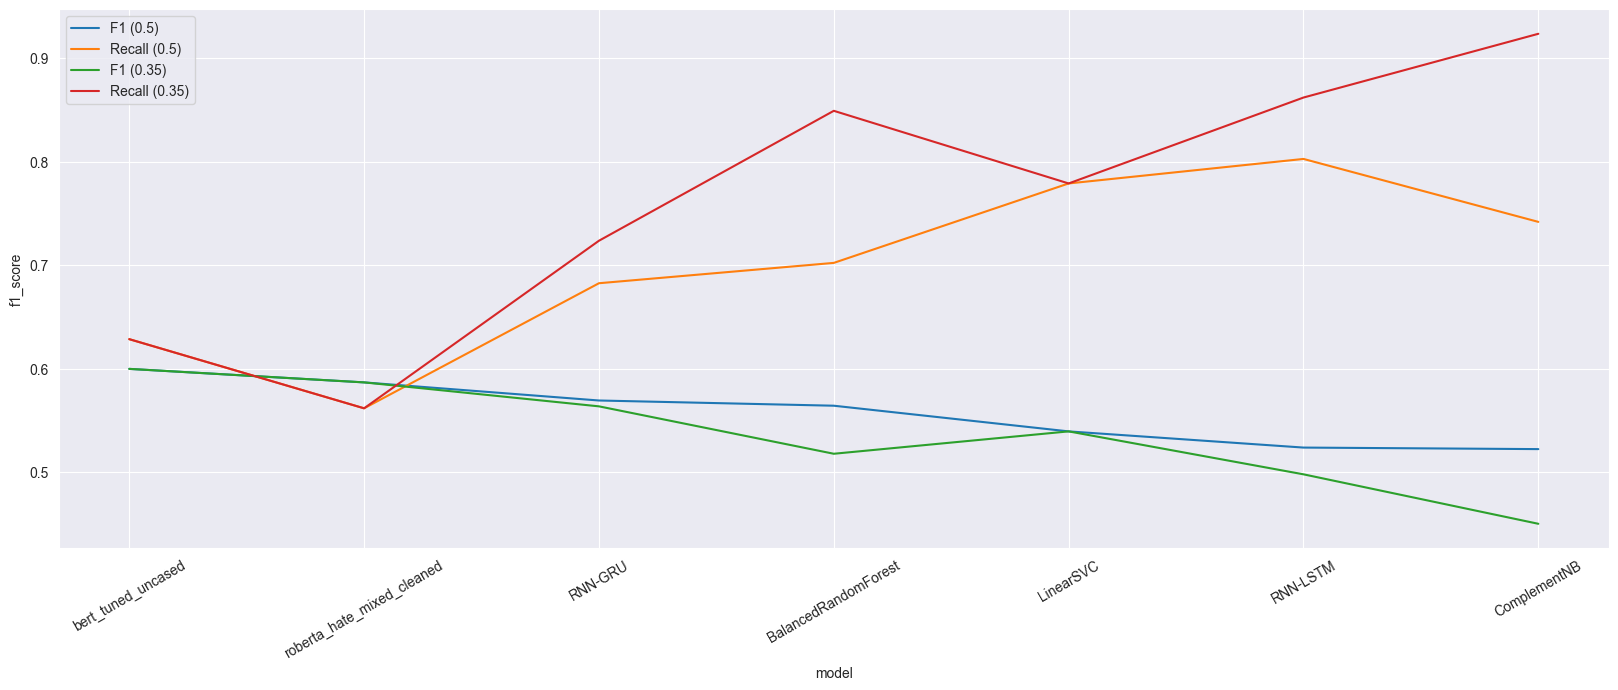

In [99]:
# Vergleich von F1-Score und Recall bei unterschiedlichem Schwellwert für test_cleaned/test_cleaned_rnn
fig, ax = plt.subplots(figsize=(20, 7))
plt.xticks(rotation=30)

sns.lineplot(data=best_cleaned, y=best_cleaned.f1_score, x=best_cleaned.model, label="F1 (0.5)")
sns.lineplot(data=best_cleaned, y=best_cleaned.recall, x=best_cleaned.model, label="Recall (0.5)")
# sns.lineplot(data=best_cleaned, y=best_cleaned.mcc, x=best_cleaned.model, label="MCC (0.5)")

sns.lineplot(data=best_cleaned_35, y=best_cleaned_35.f1_score, x=best_cleaned_35.model, label="F1 (0.35)")
sns.lineplot(data=best_cleaned_35, y=best_cleaned_35.recall, x=best_cleaned_35.model, label="Recall (0.35)")
# sns.lineplot(data=best_cleaned_35, y=best_cleaned_35.mcc, x=best_cleaned_35.model, label="MCC (0.35)")

In [104]:
# Vergleich von F1-Score und Recall bei unterschiedlichem Schwellwert für test_cleaned/test_cleaned_rnn
all_eval_dfs[(all_eval_dfs.dataset_name == "df_mixed_manual_uncleaned_new") | (all_eval_dfs.dataset_name == "df_mixed_manual_uncleaned_old")].sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
6,roberta_hate_mixed_cleaned,df_mixed_manual_uncleaned_new,498,0.50,0.891566,0.909910,0.855932,0.882096,0.783151
6,roberta_hate_mixed_cleaned,df_mixed_manual_uncleaned_new,498,0.35,0.891566,0.909910,0.855932,0.882096,0.783151
6,roberta_hate_mixed_cleaned,df_mixed_manual_uncleaned_old,498,0.35,0.841365,0.824324,0.820628,0.822472,0.679103
6,roberta_hate_mixed_cleaned,df_mixed_manual_uncleaned_old,498,0.50,0.841365,0.824324,0.820628,0.822472,0.679103
5,bert_tuned_uncased,df_mixed_manual_uncleaned_new,498,0.35,0.827309,0.812500,0.826271,0.819328,0.654050
5,bert_tuned_uncased,df_mixed_manual_uncleaned_new,498,0.50,0.827309,0.812500,0.826271,0.819328,0.654050
0,BalancedRandomForest,df_mixed_manual_uncleaned_new,498,0.35,0.809237,0.760148,0.872881,0.812623,0.626387
3,RNN-LSTM,df_mixed_manual_uncleaned_new,498,0.50,0.795181,0.727891,0.906780,0.807547,0.610671
2,LinearSVC,df_mixed_manual_uncleaned_new,498,NaN,0.809237,0.783133,0.826271,0.804124,0.619319
2,LinearSVC,df_mixed_manual_uncleaned_new,498,NaN,0.809237,0.783133,0.826271,0.804124,0.619319


#### Fazit
- Unterschied zwischen cleaned vs. uncleaned: cleaned bzw. cleaned_rnn jeweils immer besser als uncleaned
- Unterschied zwischen rnn vs. regulär:
- Unterschied zwischen Schwellwert 0.5 vs. 0.35:
    - verringerter Schwellwert bringt bei keinem Modell auf dem Test-Datensatz eine Verbesserung des F1-Scores; auf den manual-labeled sind Ausnahmen zu erkennen, bei denen sich die Performance von 0.5 zu 0.35 leicht verbessert
    - bei Bert & Roberta gar keine Veränderung => Modelle klassifizieren mit hoher Wahrscheinlichkeit (unabhängig davon, ob die Klassifikation richtig/falsch ist), wenige Grenzfälle
- Beste Modelle
    - auf den Testdaten performen 1. Bert, 2. Roberta, 3. GRU am besten
    - auf den manuell gelabelten Daten performen 1. Roberta, 2. Bert, 3. restliche Modelle mit F1-Score zwischen 81-79%

### 4. Detaillierte Evaluation - Tweetbetrachtung

Fragen:
- gibt es Tweets, die von keinem Modell korrekt klassifiziert werden können? bzw. nur von wenigen? was haben diese Tweets gemeinsam?
- gibt es Tweets, die von allen Modellen korrekt klassifiziert werden können? bzw. von vielen? was haben diese Tweets gemeinsam?
-


In [133]:
def create_false_tweet_df(tweet_col, label_col, original_df, threshold):
    merged_false = original_df.copy()

    add_pred_and_probas(model=ensemble_model,
                        vectorizer=ensemble_vectorizer,
                        data=merged_false,
                        tweet_name=tweet_col,
                        threshold=threshold)
    merged_false.rename(columns={'zero_proba': '0_ens',
                                 'one_proba': '1_ens',
                                 'pred': 'pred_ens'}, inplace=True)

    add_pred_and_probas(model=nb_model,
                        vectorizer=nb_vectorizer,
                        data=merged_false,
                        tweet_name=tweet_col,
                        threshold=threshold)
    merged_false.rename(columns={'zero_proba': '0_nb',
                                 'one_proba': '1_nb',
                                 'pred': 'pred_nb'}, inplace=True)

    add_pred_and_probas_svm(model=svm_model,
                            vectorizer=svm_vectorizer,
                            data=merged_false,
                            tweet_name=tweet_col,
                            threshold=threshold)
    merged_false.rename(columns={'zero_proba': '0_svm',
                                 'one_proba': '1_svm',
                                 'pred': 'pred_svm'}, inplace=True)

    add_pred_and_probas_lstm(model=lstm_model,
                             tokenizer=lstm_tokenizer,
                             vectorizer=lstm_glove_embeddings,
                             data=merged_false,
                             tweet_name=tweet_col,
                             threshold=threshold)
    merged_false.rename(columns={'zero_proba': '0_lstm',
                                 'one_proba': '1_lstm',
                                 'pred': 'pred_lstm'}, inplace=True)

    add_pred_and_probas_gru(model=gru_model,
                            tokenizer=gru_tokenizer,
                            data=merged_false,
                            tweet_name=tweet_col,
                            threshold=threshold,
                            max_len=40)
    merged_false.rename(columns={'zero_proba': '0_gru',
                                 'one_proba': '1_gru',
                                 'pred': 'pred_gru'}, inplace=True)

    add_pred_and_probas_bert(model=bert_model,
                             tokenizer=bert_tokenizer,
                             data=merged_false,
                             label_name=label_col,
                             tweet_name=tweet_col,
                             batch_size=16,
                             threshold=threshold)
    merged_false.rename(columns={'zero_proba': '0_bert',
                                 'one_proba': '1_bert',
                                 'pred': 'pred_bert'}, inplace=True)

    add_pred_and_probas_bert(model=roberta_model,
                             tokenizer=roberta_tokenizer,
                             data=merged_false,
                             label_name=label_col,
                             tweet_name=tweet_col,
                             batch_size=16,
                             threshold=threshold)
    merged_false.rename(columns={'zero_proba': '0_rob',
                                 'one_proba': '1_rob',
                                 'pred': 'pred_rob'}, inplace=True)

    return merged_false

In [134]:
def get_all_false_merged(merged_false, label_col):
    all_false_merged = merged_false[
        (merged_false.pred_ens != merged_false[label_col]) &
        (merged_false.pred_nb != merged_false[label_col]) &
        (merged_false.pred_svm != merged_false[label_col]) &
        (merged_false.pred_gru != merged_false[label_col]) &
        (merged_false.pred_lstm != merged_false[label_col]) &
        (merged_false.pred_bert != merged_false[label_col]) &
        (merged_false.pred_rob != merged_false[label_col])]

    print("Anzahl falsch vorhergesagter Tweets (von allen Modelle):", len(all_false_merged), "/", len(merged_false),
          "| Anteil: ", round((len(all_false_merged) / len(merged_false) * 100), 2), "%")
    print("-- davon Label 0:", len(all_false_merged[all_false_merged[label_col] == 0]))
    print("-- davon Label 1:", len(all_false_merged[all_false_merged[label_col] == 1]))

    return all_false_merged

In [135]:
def get_num_of_false(df, label_col, model_pred_col):
    return len(
        df[((df[label_col] == 0) & (df[model_pred_col] == 1)) | ((df[label_col] == 1) & (df[model_pred_col] == 0))])

In [136]:
def get_mostly_false_merged(merged_false, label_col):
    merged_false["preds"] = merged_false.pred_ens.values + \
                            merged_false.pred_nb.values + \
                            merged_false.pred_svm.values + \
                            merged_false.pred_gru.values + \
                            merged_false.pred_lstm.values + \
                            merged_false.pred_bert.values + \
                            merged_false.pred_rob.values
    mostly_false_merge = merged_false[((merged_false[label_col] == 0) & (merged_false.preds >= 4)) | (
            (merged_false[label_col] == 1) & (merged_false.preds <= 4))]

    print("Anzahl falsch vorhergesagter Tweets (4/7 Modelle falsch):", len(mostly_false_merge), "/", len(merged_false),
          "| Anteil: ", round((len(mostly_false_merge) / len(merged_false) * 100), 2), "%")
    print("-- davon Label 0:", len(mostly_false_merge[mostly_false_merge[label_col] == 0]))
    print("-- davon Label 1:", len(mostly_false_merge[mostly_false_merge[label_col] == 1]))

    print("Modelle:")
    print("-- Ensemble: \t", get_num_of_false(mostly_false_merge, label_col, "pred_ens"), "/", len(mostly_false_merge),
          " - ",
          round((get_num_of_false(mostly_false_merge, label_col, "pred_ens") / len(mostly_false_merge)) * 100, 2), "%")
    print("-- NB: \t\t\t", get_num_of_false(mostly_false_merge, label_col, "pred_nb"), "/", len(mostly_false_merge),
          " - ", round((get_num_of_false(mostly_false_merge, label_col, "pred_nb") / len(mostly_false_merge)) * 100, 2),
          "%")
    print("-- SVM: \t\t", get_num_of_false(mostly_false_merge, label_col, "pred_svm"), "/", len(mostly_false_merge),
          " - ",
          round((get_num_of_false(mostly_false_merge, label_col, "pred_svm") / len(mostly_false_merge)) * 100, 2), "%")
    print("-- GRU: \t\t", get_num_of_false(mostly_false_merge, label_col, "pred_gru"), "/", len(mostly_false_merge),
          " - ",
          round((get_num_of_false(mostly_false_merge, label_col, "pred_gru") / len(mostly_false_merge)) * 100, 2), "%")
    print("-- LSTM: \t\t", get_num_of_false(mostly_false_merge, label_col, "pred_lstm"), "/", len(mostly_false_merge),
          " - ",
          round((get_num_of_false(mostly_false_merge, label_col, "pred_lstm") / len(mostly_false_merge)) * 100, 2), "%")
    print("-- BERT: \t\t", get_num_of_false(mostly_false_merge, label_col, "pred_bert"), "/", len(mostly_false_merge),
          " - ",
          round((get_num_of_false(mostly_false_merge, label_col, "pred_bert") / len(mostly_false_merge)) * 100, 2), "%")
    print("-- ROBERTA: \t", get_num_of_false(mostly_false_merge, label_col, "pred_rob"), "/", len(mostly_false_merge),
          " - ",
          round((get_num_of_false(mostly_false_merge, label_col, "pred_rob") / len(mostly_false_merge)) * 100, 2), "%")

    return mostly_false_merge

#### 4.1 manuell gelabelte Tweets (new) - Schwellwert 0.5

In [110]:
merged_false_manual1 = pd.read_csv("evaluation_data/merged_false_manual1.csv", index_col=0)

In [111]:
all_false_merged_manual1 = get_all_false_merged(merged_false_manual1, label_col="label_manual")
all_false_merged_manual1

Anzahl falsch vorhergesagter Tweets (von allen Modelle): 8 / 498 | Anteil:  1.61 %
-- davon Label 0: 6
-- davon Label 1: 2


,label_manual,tweet,0_ens,1_ens,pred_ens,0_nb,1_nb,pred_nb,0_svm,1_svm,...,0_gru,1_gru,pred_gru,0_bert,1_bert,pred_bert,0_rob,1_rob,pred_rob,preds
81,1,Man just wait till the US leaves Afghanistan s...,0.86,0.14,0,0.563057,0.436943,0,0,0,...,0.821766,0.178234,0,0.565452,0.434548,0,0.990371,0.009629,0,0
2,0,"Those fucker give true muslims a bad name, kil...",0.22,0.78,1,0.255596,0.744404,1,0,0,...,0.424501,0.575499,1,0.241992,0.758008,1,0.036360,0.963640,1,7
12,0,Your gf is a whore I bet,0.21,0.79,1,0.114762,0.885238,1,0,0,...,0.036421,0.963579,1,0.297317,0.702683,1,0.039591,0.960409,1,7
15,0,Somebody find me this fucking pussy ass bitch URL,0.29,0.71,1,0.390066,0.609934,1,0,0,...,0.032229,0.967771,1,0.264960,0.735040,1,0.272777,0.727223,1,7
65,0,Get the fuck out stupid bitch,0.35,0.65,1,0.292034,0.707966,1,0,0,...,0.073379,0.926621,1,0.427763,0.572237,1,0.441481,0.558519,1,7
57,0,You're a retard too so what's one retard repla...,0.23,0.77,1,0.252714,0.747286,1,0,0,...,0.152197,0.847803,1,0.346516,0.653484,1,0.198952,0.801048,1,7
70,1,RT @user: Ô∏èObama swindling future generation...,0.82,0.18,0,0.514828,0.485172,0,0,0,...,0.979549,0.020451,0,0.956755,0.043245,0,0.831532,0.168468,0,0
73,0,do you have autism or something? why do you ta...,0.04,0.96,1,0.392299,0.607701,1,0,0,...,0.019523,0.980477,1,0.475986,0.524014,1,0.047550,0.952450,1,7


In [112]:
mostly_false_merged_manual1 = get_mostly_false_merged(merged_false_manual1, label_col="label_manual")
mostly_false_merged_manual1

Anzahl falsch vorhergesagter Tweets (4/7 Modelle falsch): 85 / 498 | Anteil:  17.07 %
-- davon Label 0: 44
-- davon Label 1: 41
Modelle:
-- Ensemble: 	 67 / 85  -  78.82 %
-- NB: 			 50 / 85  -  58.82 %
-- SVM: 		 60 / 85  -  70.59 %
-- GRU: 		 55 / 85  -  64.71 %
-- LSTM: 		 64 / 85  -  75.29 %
-- BERT: 		 59 / 85  -  69.41 %
-- ROBERTA: 	 36 / 85  -  42.35 %


,label_manual,tweet,0_ens,1_ens,pred_ens,0_nb,1_nb,pred_nb,0_svm,1_svm,...,0_gru,1_gru,pred_gru,0_bert,1_bert,pred_bert,0_rob,1_rob,pred_rob,preds
10,1,"Close your fucking legs, hoe. Use birth contro...",0.60,0.40,0,0.527259,0.472741,0,0,0,...,0.006292,0.993708,1,0.713035,0.286965,0,0.158761,0.841239,1,4
11,1,@user @user Please take away their license to ...,0.70,0.30,0,0.450629,0.549371,1,0,0,...,0.997577,0.002423,0,0.865542,0.134458,0,0.961045,0.038955,0,2
23,1,My God look at these BARBARIC PPL. And these p...,0.93,0.07,0,0.376031,0.623969,1,0,0,...,0.942953,0.057047,0,0.188737,0.811263,1,0.013796,0.986204,1,4
80,1,@user Fuck education they need castration,0.50,0.50,1,0.378660,0.621340,1,0,0,...,0.823851,0.176149,0,0.649839,0.350161,0,0.118078,0.881922,1,4
81,1,Man just wait till the US leaves Afghanistan s...,0.86,0.14,0,0.563057,0.436943,0,0,0,...,0.821766,0.178234,0,0.565452,0.434548,0,0.990371,0.009629,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,1,This is what happens when you let gays Marry,0.92,0.08,0,0.426424,0.573576,1,0,0,...,0.998126,0.001874,0,0.358095,0.641905,1,0.985978,0.014022,0,2
77,0,Never ask your gay friends to hide their ident...,0.18,0.82,1,0.451460,0.548540,1,0,0,...,0.128082,0.871918,1,0.356391,0.643609,1,0.990366,0.009634,0,6
84,0,I'm delighted no one should bye anything from ...,0.67,0.33,0,0.302098,0.697902,1,0,0,...,0.241194,0.758806,1,0.571151,0.428849,0,0.606780,0.393220,0,4
85,0,John Marksman wtf she's a little girl. Fucking...,0.18,0.82,1,0.263713,0.736287,1,0,0,...,0.288606,0.711394,1,0.588637,0.411363,0,0.932846,0.067154,0,5


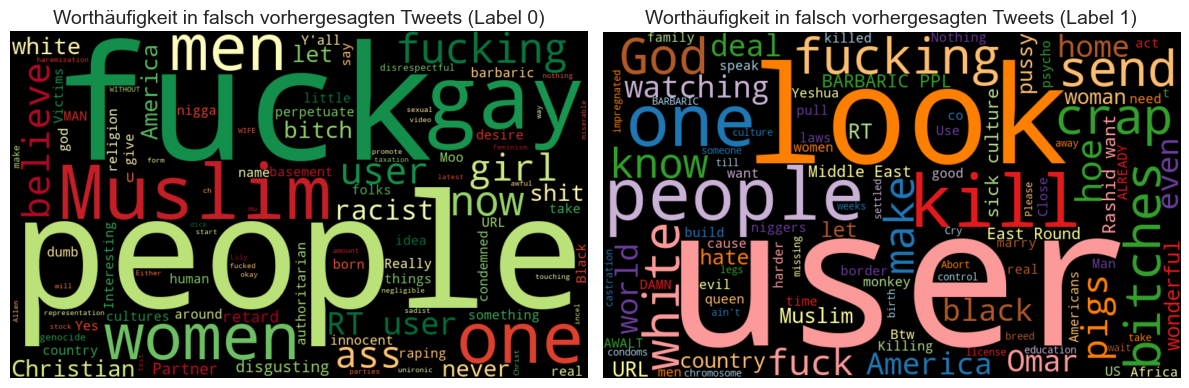

In [113]:
print_wordcloud(mostly_false_merged_manual1, tweet_col="tweet", label_col="label_manual")

##### Erkenntnisse
- falsch von allen Modellen sehr gering (<2%)
- Mehrheit falsch schon 17%
- Tweets bei allen falsch: vorhergesagt als 1 (true 0) enthalten zwar (krasse) Beleidigungen, sind aber kein Hate Speech
- Label 1 bei Mehrheit falsch: enthält Schlagworte, die man mit Hate Speech in Verbindung bringen könnte bzw. die häufig in HS-Tweets vorkommen (Personengruppen wie muslim, women oder Beleidigungen wie bitch, gay (gay an sich keine Beleidigung, wird aber häufig als solche verwendet))
- Label 0 bei Mehrheit falsch: die Schlagworte für HS fehlen bzw. kommen nicht so häufig vor

#### 4.2 manuell gelabelte Tweets (new) - Schwellwert 0.35

In [114]:
merged_false_manual2 = pd.read_csv("evaluation_data/merged_false_manual2.csv", index_col=0)

In [115]:
all_false_merged_manual2 = get_all_false_merged(merged_false_manual2, label_col="label_manual")
all_false_merged_manual2

Anzahl falsch vorhergesagter Tweets (von allen Modelle): 8 / 498 | Anteil:  1.61 %
-- davon Label 0: 8
-- davon Label 1: 0


,label_manual,tweet,0_ens,1_ens,pred_ens,0_nb,1_nb,pred_nb,0_svm,1_svm,...,0_gru,1_gru,pred_gru,0_bert,1_bert,pred_bert,0_rob,1_rob,pred_rob,preds
66,0,RT @user: We Muslims have no military honour w...,0.46,0.54,1,0.214399,0.785601,1,0,0,...,0.006515,0.993485,1,0.596255,0.403745,1,0.008101,0.991899,1,7
2,0,"Those fucker give true muslims a bad name, kil...",0.22,0.78,1,0.255596,0.744404,1,0,0,...,0.424501,0.575499,1,0.241992,0.758008,1,0.036360,0.963640,1,7
12,0,Your gf is a whore I bet,0.21,0.79,1,0.114762,0.885238,1,0,0,...,0.036421,0.963579,1,0.297317,0.702683,1,0.039591,0.960409,1,7
15,0,Somebody find me this fucking pussy ass bitch URL,0.29,0.71,1,0.390066,0.609934,1,0,0,...,0.032229,0.967771,1,0.264960,0.735040,1,0.272777,0.727223,1,7
65,0,Get the fuck out stupid bitch,0.35,0.65,1,0.292034,0.707966,1,0,0,...,0.073379,0.926621,1,0.427763,0.572237,1,0.441481,0.558519,1,7
74,0,RT @user: Wat type of bitch ass nigga rape a i...,0.38,0.62,1,0.450220,0.549780,1,0,0,...,0.505137,0.494863,1,0.359640,0.640360,1,0.085985,0.914015,1,7
57,0,You're a retard too so what's one retard repla...,0.23,0.77,1,0.252714,0.747286,1,0,0,...,0.152197,0.847803,1,0.346516,0.653484,1,0.198952,0.801048,1,7
73,0,do you have autism or something? why do you ta...,0.04,0.96,1,0.392299,0.607701,1,0,0,...,0.019523,0.980477,1,0.475986,0.524014,1,0.047550,0.952450,1,7


In [116]:
mostly_false_merged_manual2 = get_mostly_false_merged(merged_false_manual2, label_col="label_manual")
mostly_false_merged_manual2

Anzahl falsch vorhergesagter Tweets (4/7 Modelle falsch): 89 / 498 | Anteil:  17.87 %
-- davon Label 0: 58
-- davon Label 1: 31
Modelle:
-- Ensemble: 	 67 / 89  -  75.28 %
-- NB: 			 60 / 89  -  67.42 %
-- SVM: 		 60 / 89  -  67.42 %
-- GRU: 		 60 / 89  -  67.42 %
-- LSTM: 		 70 / 89  -  78.65 %
-- BERT: 		 65 / 89  -  73.03 %
-- ROBERTA: 	 38 / 89  -  42.7 %


,label_manual,tweet,0_ens,1_ens,pred_ens,0_nb,1_nb,pred_nb,0_svm,1_svm,...,0_gru,1_gru,pred_gru,0_bert,1_bert,pred_bert,0_rob,1_rob,pred_rob,preds
11,1,@user @user Please take away their license to ...,0.70,0.30,0,0.450629,0.549371,1,0,0,...,0.997577,0.002423,0,0.865542,0.134458,0,0.961045,0.038955,0,2
23,1,My God look at these BARBARIC PPL. And these p...,0.93,0.07,0,0.376031,0.623969,1,0,0,...,0.942953,0.057047,0,0.188737,0.811263,1,0.013796,0.986204,1,4
81,1,Man just wait till the US leaves Afghanistan s...,0.86,0.14,0,0.563057,0.436943,1,0,0,...,0.821766,0.178234,0,0.565452,0.434548,1,0.990371,0.009629,0,2
16,0,illegal immigrants =/= legal immigrants. in ev...,0.59,0.41,1,0.398594,0.601406,1,0,0,...,0.497590,0.502410,1,0.780791,0.219209,0,0.975723,0.024277,0,4
21,0,unironic incel parties will start to form. no ...,0.75,0.25,0,0.556272,0.443728,1,0,0,...,0.036047,0.963953,1,0.194741,0.805259,1,0.442455,0.557545,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,1,This is what happens when you let gays Marry,0.92,0.08,0,0.426424,0.573576,1,0,0,...,0.998126,0.001874,0,0.358095,0.641905,1,0.985978,0.014022,0,2
77,0,Never ask your gay friends to hide their ident...,0.18,0.82,1,0.451460,0.548540,1,0,0,...,0.128082,0.871918,1,0.356391,0.643609,1,0.990366,0.009634,0,6
84,0,I'm delighted no one should bye anything from ...,0.67,0.33,0,0.302098,0.697902,1,0,0,...,0.241194,0.758806,1,0.571151,0.428849,1,0.606780,0.393220,1,6
85,0,John Marksman wtf she's a little girl. Fucking...,0.18,0.82,1,0.263713,0.736287,1,0,0,...,0.288606,0.711394,1,0.588637,0.411363,1,0.932846,0.067154,0,6


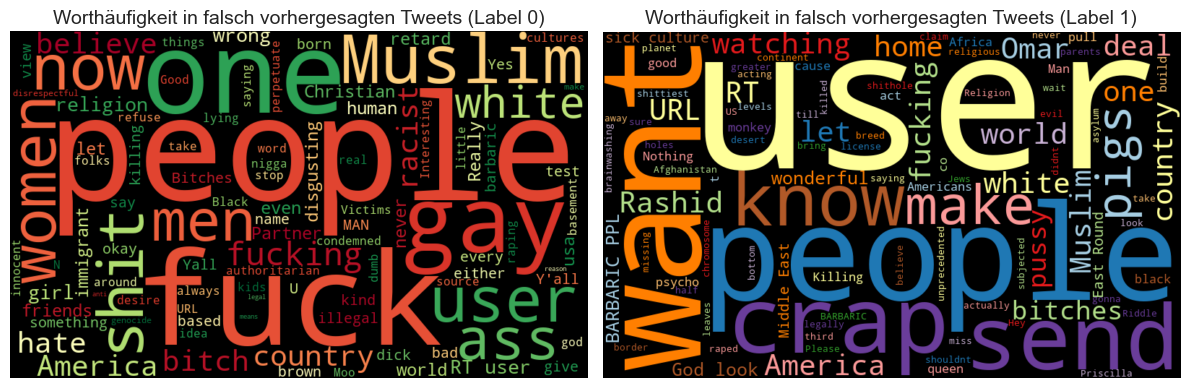

In [117]:
print_wordcloud(mostly_false_merged_manual2, tweet_col="tweet", label_col="label_manual")

##### Erkenntnisse
- falsch von allen Modellen sehr gering (<2%) => es sind aber nicht (alles) die selben Tweets wie beim Schwellwert 0.5!
- Mehrheit falsch schon 17.8% (4 Tweets mehr => deckt sich mit Kapitel 3, in denen ersichtlich ist, dass durch den verringerten Schwellwert kein Performancegewinn erzielt wird)
Rest wie bei Schwellwert 0.5
- Tweets bei allen falsch: vorhergesagt als 1 (true 0) enthalten zwar (krasse) Beleidigungen, sind aber kein Hate Speech
- Label 1 bei Mehrheit falsch: enthält Schlagworte, die man mit Hate Speech in Verbindung bringen könnte bzw. die häufig in HS-Tweets vorkommen (Personengruppen wie muslim, women oder Beleidigungen wie bitch, gay (gay an sich keine Beleidigung, wird aber häufig als solche verwendet))
- Label 0 bei Mehrheit falsch: die Schlagworte für HS fehlen bzw. kommen nicht so häufig vor

#### 4.3 Mixed-Test cleaned - Schwellwert 0.5

In [150]:
merged_false_tweet_cleaned1 = pd.read_csv("evaluation_data/merged_false_tweet_cleaned1.csv", index_col=0)

FileNotFoundError: [Errno 2] No such file or directory: 'evaluation_data/merged_false_tweet_cleaned1.csv'

In [151]:
merged_false_tweet_cleaned1

NameError: name 'merged_false_tweet_cleaned1' is not defined

In [152]:
all_false_merged_tweet_cleaned1 = get_all_false_merged(merged_false_tweet_cleaned1, label_col="label")
all_false_merged_tweet_cleaned1

NameError: name 'merged_false_tweet_cleaned1' is not defined

In [153]:
mostly_false_merged_tweet_cleaned1 = get_mostly_false_merged(merged_false_tweet_cleaned1, label_col="label")
mostly_false_merged_tweet_cleaned1

NameError: name 'merged_false_tweet_cleaned1' is not defined

In [154]:
print_wordcloud(mostly_false_merged_tweet_cleaned1, tweet_col="tweet", label_col="label")

NameError: name 'mostly_false_merged_tweet_cleaned1' is not defined

#### 4.4 Mixed-Test cleaned - Schwellwert 0.35

In [155]:
merged_false_tweet_cleaned2 = pd.read_csv("evaluation_data/merged_false_tweet_cleaned2.csv", index_col=0)

FileNotFoundError: [Errno 2] No such file or directory: 'evaluation_data/merged_false_tweet_cleaned2.csv'

In [156]:
merged_false_tweet_cleaned2

NameError: name 'merged_false_tweet_cleaned2' is not defined

In [157]:
all_false_merged_tweet_cleaned2 = get_all_false_merged(merged_false_tweet_cleaned2, label_col="label")
all_false_merged_tweet_cleaned2

NameError: name 'merged_false_tweet_cleaned2' is not defined

In [158]:
mostly_false_merged_tweet_cleaned2 = get_mostly_false_merged(merged_false_tweet_cleaned2, label_col="label")
mostly_false_merged_tweet_cleaned2

NameError: name 'merged_false_tweet_cleaned2' is not defined

In [159]:
print_wordcloud(mostly_false_merged_tweet_cleaned2, tweet_col="tweet", label_col="label")

NameError: name 'mostly_false_merged_tweet_cleaned2' is not defined

### 5. Vergleich manuell gelabelt new vs. old

#### 5.1 Allgemeiner Metrikenvergleich

In [160]:
manual_new_metrics1 = pd.read_csv("evaluation_data/evaluation_mixed_manual_uncleaned_new.csv")
manual_new_metrics1

,Unnamed: 0,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
0,0,BalancedRandomForest,df_mixed_manual_uncleaned_new,498,0.5,0.807229,0.824074,0.754237,0.787611,0.613782
1,1,ComplementNB,df_mixed_manual_uncleaned_new,498,0.5,0.746988,0.665663,0.936441,0.778169,0.543140
2,2,LinearSVC,df_mixed_manual_uncleaned_new,498,NaN,0.809237,0.783133,0.826271,0.804124,0.619319
3,3,RNN-LSTM,df_mixed_manual_uncleaned_new,498,0.5,0.795181,0.727891,0.906780,0.807547,0.610671
4,4,RNN-GRU,df_mixed_manual_uncleaned_new,498,0.5,0.817269,0.834101,0.766949,0.799117,0.633943
5,5,bert_tuned_uncased,df_mixed_manual_uncleaned_new,498,0.5,0.827309,0.812500,0.826271,0.819328,0.654050
6,6,roberta_hate_mixed_cleaned,df_mixed_manual_uncleaned_new,498,0.5,0.891566,0.909910,0.855932,0.882096,0.783151


In [161]:
manual_old_metrics1 = pd.read_csv("evaluation_data/evaluation_mixed_manual_uncleaned_old.csv")
manual_old_metrics1

,Unnamed: 0,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
0,0,BalancedRandomForest,df_mixed_manual_uncleaned_old,498,0.5,0.773092,0.754630,0.730942,0.742597,0.540036
1,1,ComplementNB,df_mixed_manual_uncleaned_old,498,0.5,0.696787,0.608434,0.905830,0.727928,0.456863
2,2,LinearSVC,df_mixed_manual_uncleaned_old,498,NaN,0.787149,0.734940,0.820628,0.775424,0.577454
3,3,RNN-LSTM,df_mixed_manual_uncleaned_old,498,0.5,0.761044,0.676871,0.892377,0.769826,0.553039
4,4,RNN-GRU,df_mixed_manual_uncleaned_old,498,0.5,0.803213,0.788018,0.766816,0.777273,0.601252
5,5,bert_tuned_uncased,df_mixed_manual_uncleaned_old,498,0.5,0.797189,0.754167,0.811659,0.781857,0.594238
6,6,roberta_hate_mixed_cleaned,df_mixed_manual_uncleaned_old,498,0.5,0.841365,0.824324,0.820628,0.822472,0.679103


<Axes: xlabel='model', ylabel='f1_score'>

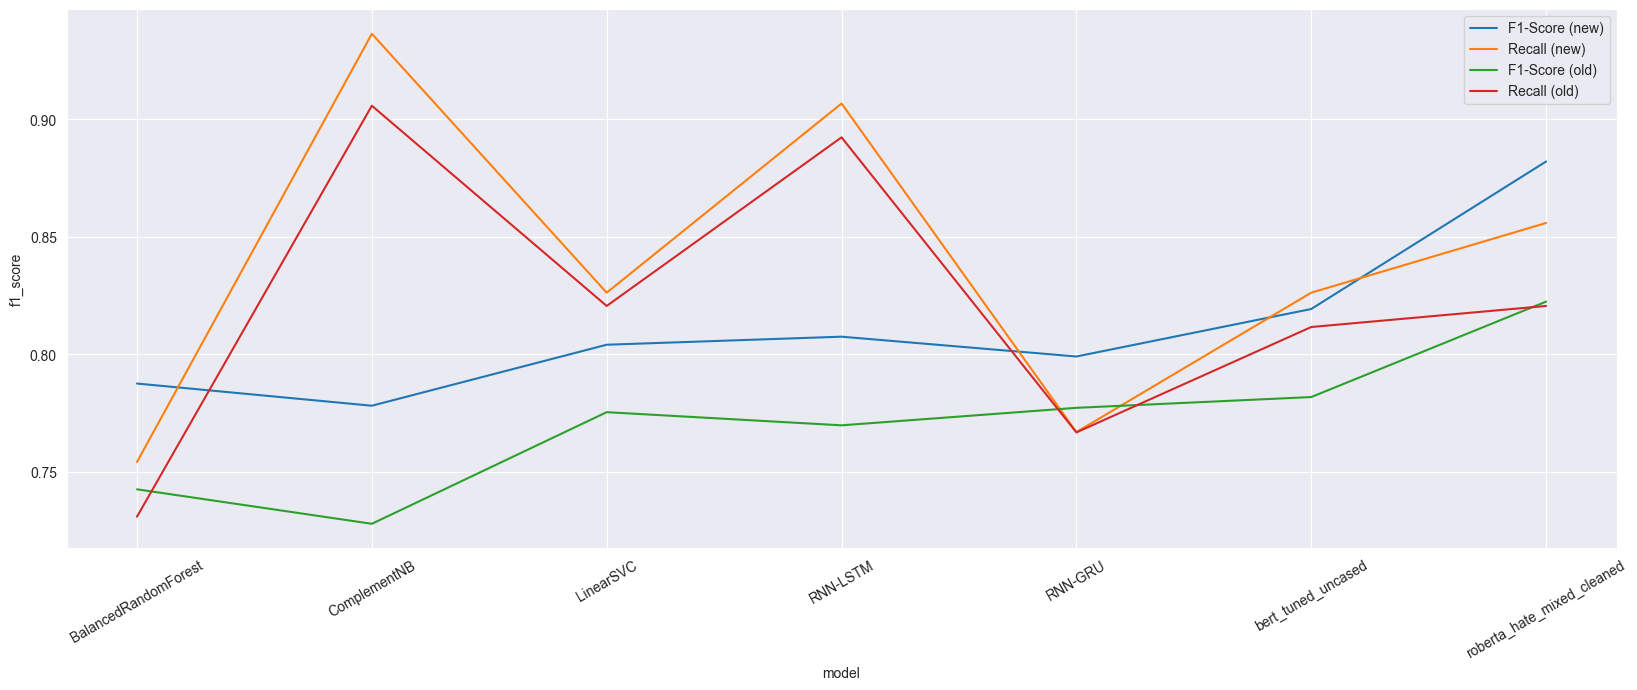

In [162]:
fig, ax = plt.subplots(figsize=(20, 7))
plt.xticks(rotation=30)
sns.lineplot(data=manual_new_metrics1, y=manual_new_metrics1.f1_score, x=manual_new_metrics1.model,
             label="F1-Score (new)")
sns.lineplot(data=manual_new_metrics1, y=manual_new_metrics1.recall, x=manual_new_metrics1.model, label="Recall (new)")
sns.lineplot(data=manual_old_metrics1, y=manual_old_metrics1.f1_score, x=manual_old_metrics1.model,
             label="F1-Score (old)")
sns.lineplot(data=manual_old_metrics1, y=manual_old_metrics1.recall, x=manual_old_metrics1.model, label="Recall (old)")

#### 5.2 Prüfung der Schnittmenge von allen falsch vorhergesagter Tweets new/old

In [137]:
merged_false_manual_new = create_false_tweet_df(tweet_col="tweet", label_col="label_manual",
                                                original_df=df_mixed_manual_uncleaned_new,
                                                threshold=0.5)
all_false_merged_manual_new = get_all_false_merged(merged_false_manual_new, label_col="label_manual")

merged_false_manual_old = create_false_tweet_df(tweet_col="tweet", label_col="label",
                                                original_df=df_mixed_manual_uncleaned_old,
                                                threshold=0.5)
all_false_merged_manual_old = get_all_false_merged(merged_false_manual_old, label_col="label")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Prediction start.


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Prediction finished.
Total Prediction took 0:01:58 (h:mm:ss)
Prediction start.
Prediction finished.
Total Prediction took 0:01:48 (h:mm:ss)
Anzahl falsch vorhergesagter Tweets (von allen Modelle): 8 / 498 | Anteil:  1.61 %
-- davon Label 0: 6
-- davon Label 1: 2
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Prediction start.
Prediction finished.
Total Prediction took 0:01:47 (h:mm:ss)
Prediction start.
Prediction finished.
Total Prediction took 0:01:47 (h:mm:ss)
Anzahl falsch vorhergesagter Tweets (von allen Modelle): 21 / 498 | Anteil:  4.22 %
-- davon Label 0: 14
-- davon Label 1: 7


In [138]:
merged_manual = pd.merge(all_false_merged_manual_new, all_false_merged_manual_old, left_index=True, right_index=True)
merged_manual = merged_manual[~merged_manual.index.duplicated(keep='first')]

print("Anzahl:", len(merged_manual))
merged_manual

Anzahl: 2


,label_manual,tweet_x,0_ens_x,1_ens_x,pred_ens_x,0_nb_x,1_nb_x,pred_nb_x,0_svm_x,1_svm_x,...,pred_lstm_y,0_gru_y,1_gru_y,pred_gru_y,0_bert_y,1_bert_y,pred_bert_y,0_rob_y,1_rob_y,pred_rob_y
2,0,"Those fucker give true muslims a bad name, kil...",0.22,0.78,1,0.255596,0.744404,1,0,0,...,1,0.424501,0.575499,1,0.241992,0.758008,1,0.036360,0.963640,1
70,1,RT @user: Ô∏èObama swindling future generation...,0.82,0.18,0,0.514828,0.485172,0,0,0,...,0,0.979549,0.020451,0,0.956755,0.043245,0,0.831532,0.168468,0


#### 5.3 Prüfung der Schnittmenge von vielen falsch vorhergesagter Tweets new/old

In [139]:
merged_mostly_false_manual_new = get_mostly_false_merged(merged_false_manual_new, label_col="label_manual")
merged_mostly_false_manual_old = get_mostly_false_merged(merged_false_manual_old, label_col="label")

Anzahl falsch vorhergesagter Tweets (4/7 Modelle falsch): 85 / 498 | Anteil:  17.07 %
-- davon Label 0: 44
-- davon Label 1: 41
Modelle:
-- Ensemble: 	 67 / 85  -  78.82 %
-- NB: 			 50 / 85  -  58.82 %
-- SVM: 		 60 / 85  -  70.59 %
-- GRU: 		 55 / 85  -  64.71 %
-- LSTM: 		 64 / 85  -  75.29 %
-- BERT: 		 59 / 85  -  69.41 %
-- ROBERTA: 	 36 / 85  -  42.35 %
Anzahl falsch vorhergesagter Tweets (4/7 Modelle falsch): 99 / 498 | Anteil:  19.88 %
-- davon Label 0: 57
-- davon Label 1: 42
Modelle:
-- Ensemble: 	 82 / 99  -  82.83 %
-- NB: 			 70 / 99  -  70.71 %
-- SVM: 		 71 / 99  -  71.72 %
-- GRU: 		 65 / 99  -  65.66 %
-- LSTM: 		 78 / 99  -  78.79 %
-- BERT: 		 73 / 99  -  73.74 %
-- ROBERTA: 	 59 / 99  -  59.6 %


In [140]:
merged_manual_mostly = pd.merge(merged_mostly_false_manual_new, merged_mostly_false_manual_old, left_index=True,
                                right_index=True)
merged_manual_mostly = merged_manual_mostly[~merged_manual_mostly.index.duplicated(keep='first')]

print("Anzahl:", len(merged_manual_mostly))
merged_manual_mostly

Anzahl: 50


,label_manual,tweet_x,0_ens_x,1_ens_x,pred_ens_x,0_nb_x,1_nb_x,pred_nb_x,0_svm_x,1_svm_x,...,0_gru_y,1_gru_y,pred_gru_y,0_bert_y,1_bert_y,pred_bert_y,0_rob_y,1_rob_y,pred_rob_y,preds_y
10,1,"Close your fucking legs, hoe. Use birth contro...",0.6000,0.4000,0,0.527259,0.472741,0,0,0,...,0.006292,0.993708,1,0.713035,0.286965,0,0.158761,0.841239,1,4
11,1,@user @user Please take away their license to ...,0.7000,0.3000,0,0.450629,0.549371,1,0,0,...,0.997577,0.002423,0,0.865542,0.134458,0,0.961045,0.038955,0,2
23,1,My God look at these BARBARIC PPL. And these p...,0.9300,0.0700,0,0.376031,0.623969,1,0,0,...,0.942953,0.057047,0,0.188737,0.811263,1,0.013796,0.986204,1,4
80,1,@user Fuck education they need castration,0.5000,0.5000,1,0.378660,0.621340,1,0,0,...,0.823851,0.176149,0,0.649839,0.350161,0,0.118078,0.881922,1,4
21,0,unironic incel parties will start to form. no ...,0.7500,0.2500,0,0.556272,0.443728,0,0,0,...,0.036047,0.963953,1,0.194741,0.805259,1,0.442455,0.557545,1,4
22,0,"Just stock something up your ass, you're not t...",0.3350,0.6650,1,0.404455,0.595545,1,0,0,...,0.996269,0.003731,0,0.461060,0.538940,1,0.008626,0.991374,1,4
40,0,He's a sadist. Most Muslims don't believe peo...,0.4475,0.5525,1,0.364257,0.635743,1,0,0,...,0.920300,0.079700,0,0.377988,0.622012,1,0.950608,0.049392,0,5
47,0,You're a racist and no Christian.,0.2200,0.7800,1,0.372512,0.627488,1,0,0,...,0.576759,0.423241,0,0.412939,0.587061,1,0.913791,0.086209,0,4
50,0,"Fuck you, fuck you very very mu~ch, Lily Allen...",0.3200,0.6800,1,0.274408,0.725592,1,0,0,...,0.884410,0.115590,0,0.225954,0.774046,1,0.877781,0.122219,0,5
53,0,"On behalf of all gay people, fuck off.",0.4000,0.6000,1,0.336808,0.663192,1,0,0,...,0.694199,0.305801,0,0.248105,0.751895,1,0.900433,0.099567,0,5


In [147]:
comp = merged_manual_mostly.drop(columns=['0_ens_x', '1_ens_x', '0_nb_x',
       '1_nb_x', '0_svm_x', '1_svm_x', '0_lstm_x',
       '1_lstm_x', '0_gru_x', '1_gru_x',
       '0_bert_x', '1_bert_x', '0_rob_x', '1_rob_x',
       'tweet_y', '0_ens_y', '1_ens_y',
       '0_nb_y', '1_nb_y', '0_svm_y', '1_svm_y',
       '0_lstm_y', '1_lstm_y', '0_gru_y',
       '1_gru_y', '0_bert_y', '1_bert_y',
       '0_rob_y', '1_rob_y', 'preds_y', 'preds_x'])
comp[comp.label_manual != comp.label]

,label_manual,tweet_x,pred_ens_x,pred_nb_x,pred_svm_x,pred_lstm_x,pred_gru_x,pred_bert_x,pred_rob_x,label,pred_ens_y,pred_nb_y,pred_svm_y,pred_lstm_y,pred_gru_y,pred_bert_y,pred_rob_y
23,1,My God look at these BARBARIC PPL. And these p...,0,1,0,1,0,1,1,0,0,1,0,1,0,1,1
80,1,@user Fuck education they need castration,1,1,0,1,0,0,1,0,1,1,0,1,0,0,1
47,0,You're a racist and no Christian.,1,1,0,1,0,1,0,1,1,1,0,1,0,1,0
19,0,I'm always amazed at these people who consider...,1,1,1,1,0,0,0,1,1,1,1,1,0,0,0
48,0,RT @user Women vocalists in rocks music... tho...,1,1,1,1,0,1,1,1,0,0,0,0,0,0,0
69,1,kill all the men,1,1,1,1,0,0,0,0,1,1,1,1,0,0,0
70,1,Killing all the Jews for sure,1,1,0,1,0,0,1,0,1,1,0,1,0,0,1
82,0,Says the unemployed basement dweller who spend...,1,1,0,1,0,1,0,1,1,1,0,1,0,1,0
87,1,She's never gonna get out of that third world ...,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1
91,0,Yeah! Give those homophobes a new language to ...,0,0,0,1,1,1,1,1,0,0,0,1,1,1,1


#### 5.4 Erkenntnisse
-

### 6. Erkenntisse aus allen Analysen

#### 6.1 Erkenntisse Kapitel 3
- Unterschied zwischen cleaned vs. uncleaned: cleaned bzw. cleaned_rnn jeweils immer besser als uncleaned
- Unterschied zwischen rnn vs. regulär:
- Unterschied zwischen Schwellwert 0.5 vs. 0.35:
    - verringerter Schwellwert bringt bei keinem Modell auf dem Test-Datensatz eine Verbesserung des F1-Scores; auf den manual-labeled sind Ausnahmen zu erkennen, bei denen sich die Performance von 0.5 zu 0.35 leicht verbessert
    - bei Bert & Roberta gar keine Veränderung => Modelle klassifizieren mit hoher Wahrscheinlichkeit (unabhängig davon, ob die Klassifikation richtig/falsch ist), wenige Grenzfälle
- Beste Modelle
    - auf den Testdaten performen 1. Bert, 2. Roberta, 3. GRU am besten
    - auf den manuell gelabelten Daten performen 1. Roberta, 2. Bert, 3. restliche Modelle mit F1-Score zwischen 81-79%

#### 6.2 Erkenntisse Kapitel 4 - Detaillierte Evaluation/Tweetbetrachtung

##### Erkenntnisse 4.1 (Schwellwert 0.5)
- falsch von allen Modellen sehr gering (<2%)
- Mehrheit falsch schon 17%
- Tweets bei allen falsch: vorhergesagt als 1 (true 0) enthalten zwar (krasse) Beleidigungen, sind aber kein Hate Speech
- Label 1 bei Mehrheit falsch: enthält Schlagworte, die man mit Hate Speech in Verbindung bringen könnte bzw. die häufig in HS-Tweets vorkommen (Personengruppen wie muslim, women oder Beleidigungen wie bitch, gay (gay an sich keine Beleidigung, wird aber häufig als solche verwendet))
- Label 0 bei Mehrheit falsch: die Schlagworte für HS fehlen bzw. kommen nicht so häufig vor

##### Erkenntnisse 4.2 (Schwellwert 0.35)
- falsch von allen Modellen sehr gering (<2%) => es sind aber nicht (alles) die selben Tweets wie beim Schwellwert 0.5!
- Mehrheit falsch schon 17.8% (4 Tweets mehr => deckt sich mit Kapitel 3, in denen ersichtlich ist, dass durch den verringerten Schwellwert kein Performancegewinn erzielt wird)
Rest wie bei Schwellwert 0.5
- Tweets bei allen falsch: vorhergesagt als 1 (true 0) enthalten zwar (krasse) Beleidigungen, sind aber kein Hate Speech
- Label 1 bei Mehrheit falsch: enthält Schlagworte, die man mit Hate Speech in Verbindung bringen könnte bzw. die häufig in HS-Tweets vorkommen (Personengruppen wie muslim, women oder Beleidigungen wie bitch, gay (gay an sich keine Beleidigung, wird aber häufig als solche verwendet))
- Label 0 bei Mehrheit falsch: die Schlagworte für HS fehlen bzw. kommen nicht so häufig vor

##### Erkenntnisse 4.3 (Schwellwert 0.5)

##### Erkenntnisse 4.4 (Schwellwert 0.35)

#### 6.3 Erkenntisse Kapitel 5